In [ ]:
load("ProcessData.RData")
library(jsonlite)
library(purrr)
library(data.table)
library(factoextra)
library(forcats)
library(pheatmap)
library(e1071)
library(modelr)
library(compositions)


Figure 1: We trust the data
- Mutational spectra
-nPCA?
All vs normal vs male

- Coverage + base quality
- Percentage of genome covered
- VAF (overall, and by mutation type?)

- Biological age-effect of SNVs


Part 1: Spectra and similarity


In [13]:
# Read the matrix
matrix <- read.table(
  "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/output/SBS/snvs.SBS6.all",
  sep = "\t",
  header = TRUE,
  stringsAsFactors = FALSE,
  check.names = FALSE
)

# matrix <- read.table(
#   "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/output/SBS/snvs.SBS96.all",
#   sep = "\t",
#   header = TRUE,
#   stringsAsFactors = FALSE,
#   check.names = FALSE
# )

# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(paste(hiatt_donors, collapse = "|"),
                   colnames(matrix),
                   value = TRUE)

# Row-wise sums
matrix$`Lee-Six` <- rowSums(matrix[, lee_donors, drop = FALSE])
matrix$Hiatt <- rowSums(matrix[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix$Hiatt
spectrum2 <- matrix$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance: %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity: %.4f\n", cosine_similarity))


Cosine distance: 0.0306
Cosine similarity: 0.9694


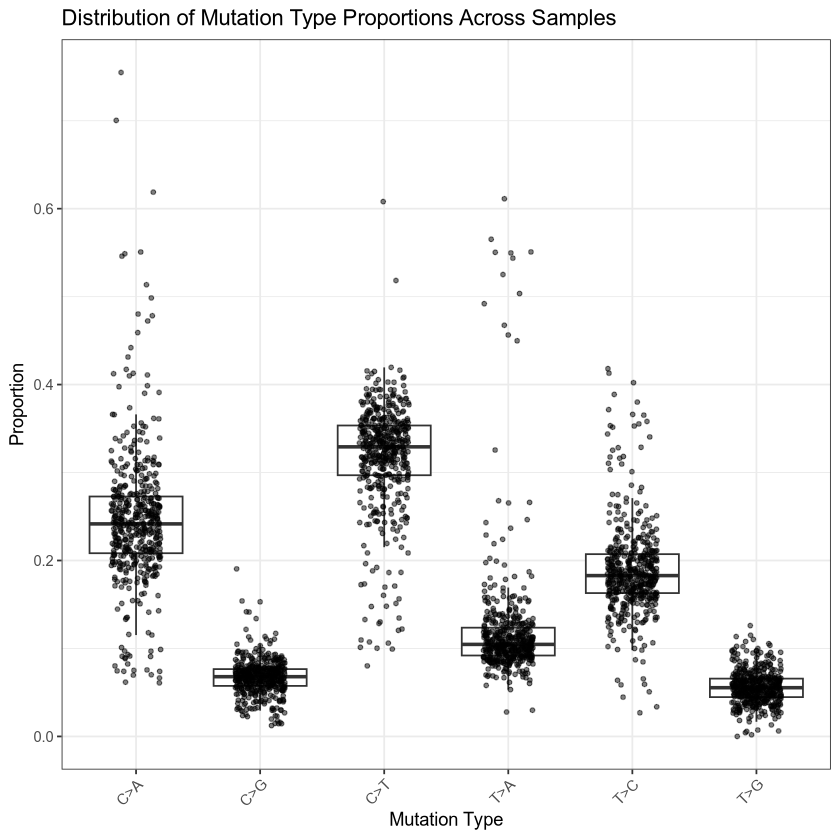

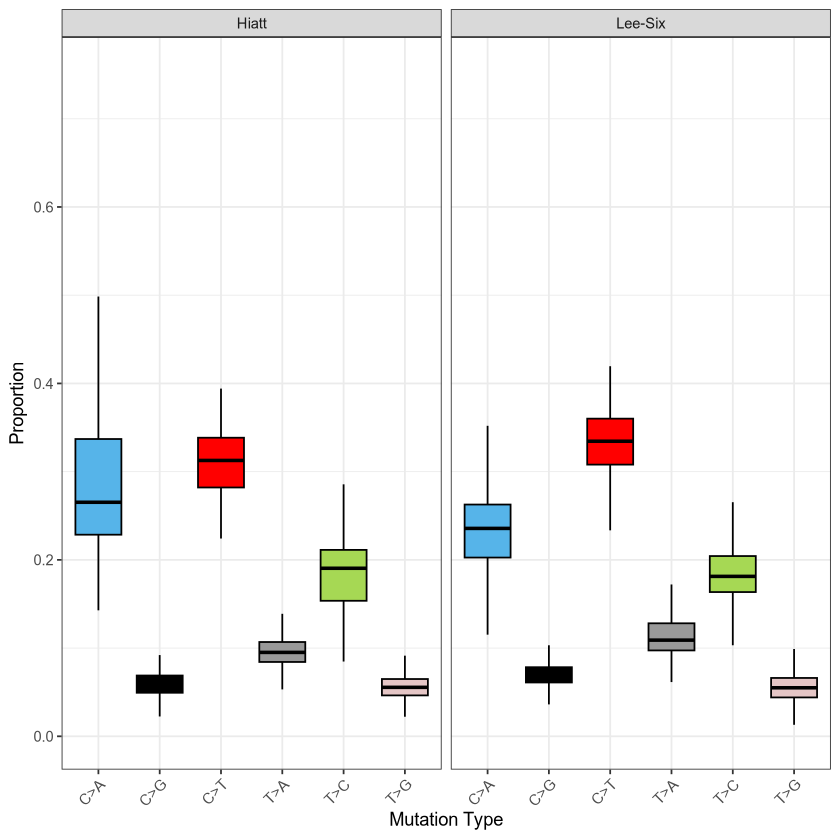

In [ ]:
# Read data
df <- matrix

# Set mutation types as rownames
rownames(df) <- df[[1]]
df <- df[, -1]

# Normalize columns to proportions
proportions <- sweep(df, 2, colSums(df), "/")

# Donor prefixes
lee_donors <- c("PD", "HLS")
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Convert to long format
df_long <- proportions %>%
  as.data.frame() %>%
  tibble::rownames_to_column("MutationType") %>%
  pivot_longer(
    cols = -MutationType,
    names_to = "Sample",
    values_to = "Proportion"
  ) %>%
  mutate(
    Cohort = case_when(
      str_starts(Sample, paste(lee_donors, collapse = "|")) ~ "Lee-Six",
      str_detect(Sample, paste(hiatt_donors, collapse = "|")) ~ "Hiatt",
      TRUE ~ "Other"
    )
  )

# ==============================
# Plot 1: Boxplot + jitter
# ==============================
ggplot(df_long, aes(x = MutationType, y = Proportion)) +
  geom_boxplot(outlier.shape = NA) +
  geom_jitter(width = 0.2, size = 1, alpha = 0.5) +
  labs(
    title = "Distribution of Mutation Type Proportions Across Samples",
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# ==============================
# Plot 2: Faceted boxplots by cohort
# ==============================
# palette <- c(
#    "C>A"="#7fb3d5","C>G"="#000000",
#    "C>T at non-CpG"="#b22222","C>T at CpG"="#dca79a",
#    "T>A"="#bfbfbf","T>C"="#b2d18c","T>G"="#e9cfc8"
#  )
mutation_colors <- c(
  "C>A" = "#7fb3d5",  # blue
  "C>G" = "#000000",  # black
  "C>T" = "#b22222",  # red
  "T>A" = "#bfbfbf",  # gray
  "T>C" = "#b2d18c",  # green
  "T>G" = "#e9cfc8"   # pink
)

df_long %>%
  filter(Cohort %in% c("Lee-Six", "Hiatt")) %>%
  ggplot(aes(
    x = MutationType,
    y = Proportion,
    fill = MutationType
  )) +
  geom_boxplot(outlier.shape = NA, color = "black") +
  facet_wrap(~ Cohort) +
  scale_fill_manual(values = mutation_colors, guide = "none") +
  labs(
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


Cosine distance (male, normal): 0.0232
Cosine similarity (male, normal): 0.9768


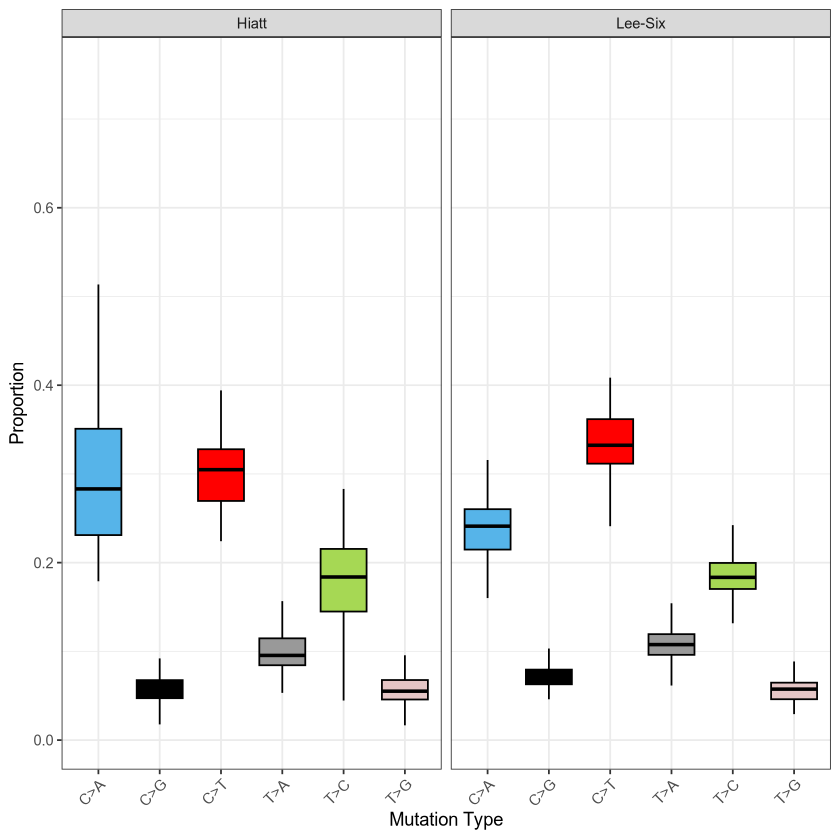

In [29]:
male_normal_crypts <- combined_df %>%
  filter(sex == "male", cohort == "normal") %>%
  pull(crypt_sample)

# Subset + plot
df_long %>%
  filter(
    Cohort %in% c("Lee-Six", "Hiatt"),
    Sample %in% male_normal_crypts
  ) %>%
  ggplot(aes(
    x = MutationType,
    y = Proportion,
    fill = MutationType
  )) +
  geom_boxplot(outlier.shape = NA, color = "black") +
  facet_wrap(~ Cohort) +
  scale_fill_manual(values = mutation_colors, guide = "none") +
  labs(
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Restrict matrix to male normal crypts only
matrix_sub <- matrix[, colnames(matrix) %in% male_normal_crypts, drop = FALSE]

# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix_sub), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(
  paste(hiatt_donors, collapse = "|"),
  colnames(matrix_sub),
  value = TRUE
)

# Row-wise sums
matrix_sub$`Lee-Six` <- rowSums(matrix_sub[, lee_donors, drop = FALSE])
matrix_sub$Hiatt <- rowSums(matrix_sub[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix_sub$Hiatt
spectrum2 <- matrix_sub$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance (male, normal): %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity (male, normal): %.4f\n", cosine_similarity))


Cosine distance (suff cov): 0.0291
Cosine similarity (suff cov): 0.9709


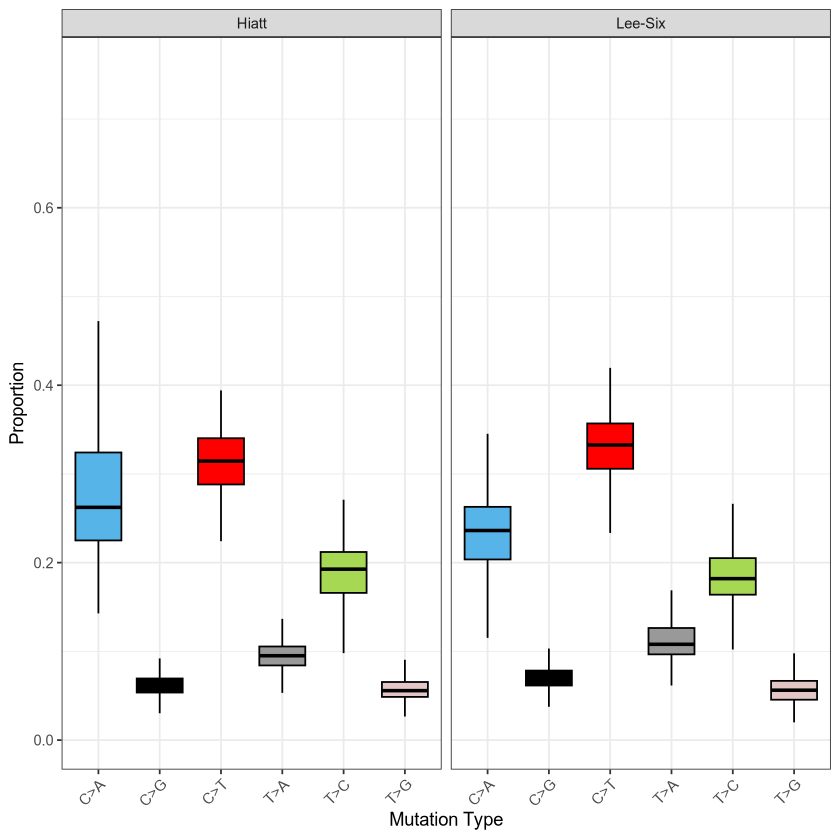

In [30]:
sufficient_cov_crypts <- combined_df %>%
  filter(coverage > 9) %>%
  pull(crypt_sample)

# Subset + plot
df_long %>%
  filter(
    Cohort %in% c("Lee-Six", "Hiatt"),
    Sample %in% sufficient_cov_crypts
  ) %>%
  ggplot(aes(
    x = MutationType,
    y = Proportion,
    fill = MutationType
  )) +
  geom_boxplot(outlier.shape = NA, color = "black") +
  facet_wrap(~ Cohort) +
  scale_fill_manual(values = mutation_colors, guide = "none") +
  labs(
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


# Restrict matrix to male normal crypts only
matrix_sub <- matrix[, colnames(matrix) %in% sufficient_cov_crypts, drop = FALSE]

# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix_sub), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(
  paste(hiatt_donors, collapse = "|"),
  colnames(matrix_sub),
  value = TRUE
)

# Row-wise sums
matrix_sub$`Lee-Six` <- rowSums(matrix_sub[, lee_donors, drop = FALSE])
matrix_sub$Hiatt <- rowSums(matrix_sub[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix_sub$Hiatt
spectrum2 <- matrix_sub$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance (suff cov): %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity (suff cov): %.4f\n", cosine_similarity))

In [31]:
# Restrict matrix to male normal crypts only
matrix_sub <- matrix[, colnames(matrix) %in% sufficient_cov_crypts, drop = FALSE]

matrix_sub <- matrix_sub[, colnames(matrix_sub) %in% male_normal_crypts, drop = FALSE]


# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix_sub), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(
  paste(hiatt_donors, collapse = "|"),
  colnames(matrix_sub),
  value = TRUE
)

# Row-wise sums
matrix_sub$`Lee-Six` <- rowSums(matrix_sub[, lee_donors, drop = FALSE])
matrix_sub$Hiatt <- rowSums(matrix_sub[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix_sub$Hiatt
spectrum2 <- matrix_sub$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance (suff cov): %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity (suff cov): %.4f\n", cosine_similarity))

Cosine distance (suff cov): 0.0190
Cosine similarity (suff cov): 0.9810


Okay let's do the PCA

In [97]:
matrix <- read.table(
  "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/output/SBS/snvs.SBS96.all",
  sep = "\t",
  header = TRUE,
  stringsAsFactors = FALSE,
  check.names = FALSE
)

matrixswitched <- t(as.data.frame(matrix[-1]))


In [98]:
prop_matrix <- matrixswitched / rowSums(matrixswitched)


In [127]:
matrix_sub <- matrix[, colnames(matrix) %in% sufficient_cov_crypts, drop = FALSE]
matrix_sub <- matrix_sub[, colnames(matrix_sub) %in% male_normal_crypts, drop = FALSE]

matrixswitched <- t(as.data.frame(matrix_sub[-1]))

prop_matrix_suff <- matrixswitched / rowSums(matrixswitched)



[1] 5.480495e-05 2.082938e-05 4.468920e-06 4.051099e-05 1.372311e-05
 [6] 4.784213e-06 1.129558e-06 9.310290e-06 5.458038e-05 3.184571e-05
[11] 3.782993e-05 4.522170e-05 3.329239e-05 1.345548e-05 1.443767e-05
[16] 5.197641e-05 1.168399e-04 2.870303e-05 1.649397e-05 4.282407e-04
[21] 4.414873e-06 1.604689e-06 3.029464e-06 5.266222e-06 1.080006e-04
[26] 4.739816e-05 5.093107e-06 1.005930e-04 4.816781e-06 4.941203e-06
[31] 1.072864e-06 7.158826e-06 4.616212e-05 4.838746e-05 2.514038e-05
[36] 5.896662e-05 9.828974e-05 1.259028e-05 1.417796e-04 5.865314e-05
[41] 1.116987e-05 2.590004e-05 1.074796e-05 1.230282e-05 2.222909e-06
[46] 2.224199e-06 6.124089e-06 4.737071e-06 9.020034e-05 3.471958e-05
[51] 4.316933e-06 5.192823e-05 3.162268e-06 3.134804e-06 6.347852e-07
[56] 4.239558e-06 4.164881e-05 4.938523e-05 3.299124e-05 3.537944e-05
[61] 8.551724e-05 2.785508e-06 6.946153e-05 4.343324e-05 2.634250e-05
[66] 1.248467e-05 1.047759e-05 2.187227e-05 2.437290e-06 1.175314e-06
[71] 8.093844e-06 7.872855e-06 1.318045e-04 9.622277e-05 2.140257e-05
[76] 1.664465e-04 1.783228e-05 6.625367e-06 7.353179e-07 3.369892e-05
[81] 7.108447e-05 5.884821e-05 2.722942e-05 5.479898e-05 3.014589e-05
[86] 7.353854e-06 1.157122e-05 1.666535e-04 1.400734e-05 9.951248e-06
[91] 8.755477e-06 2.346077e-04 5.472513e-06 4.552090e-06 4.099186e-06
[96] 1.222695e-04

[1] 0.16 0.10 0.09 0.05 0.04 0.03 0.03 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01
[16] 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
[31] 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
[46] 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
[61] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
[76] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
[91] 0.00 0.00 0.00 0.00 0.00 0.00

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


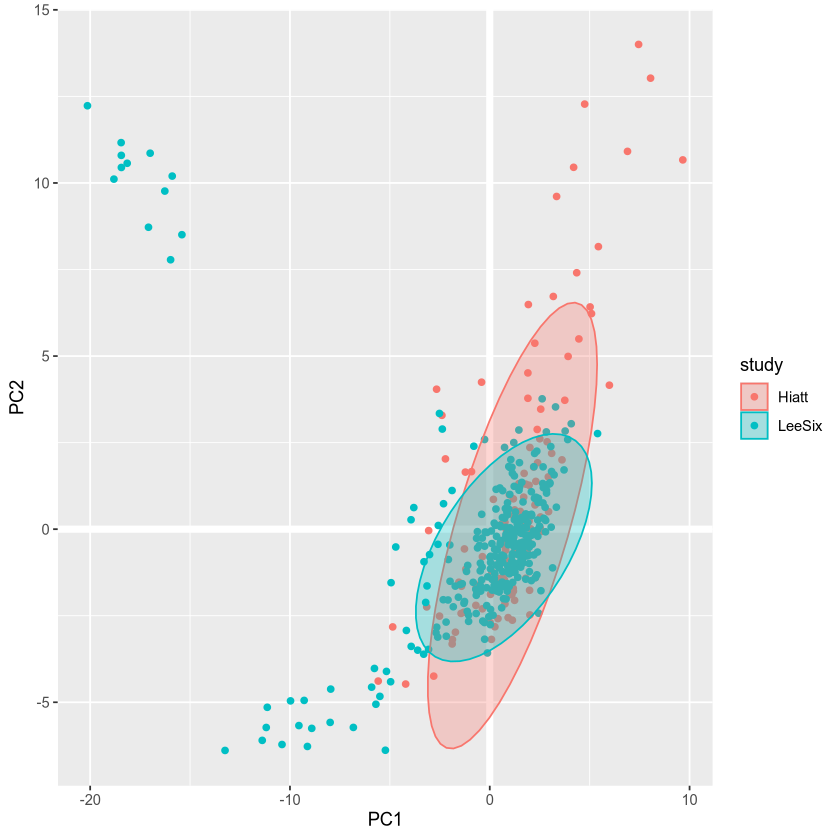

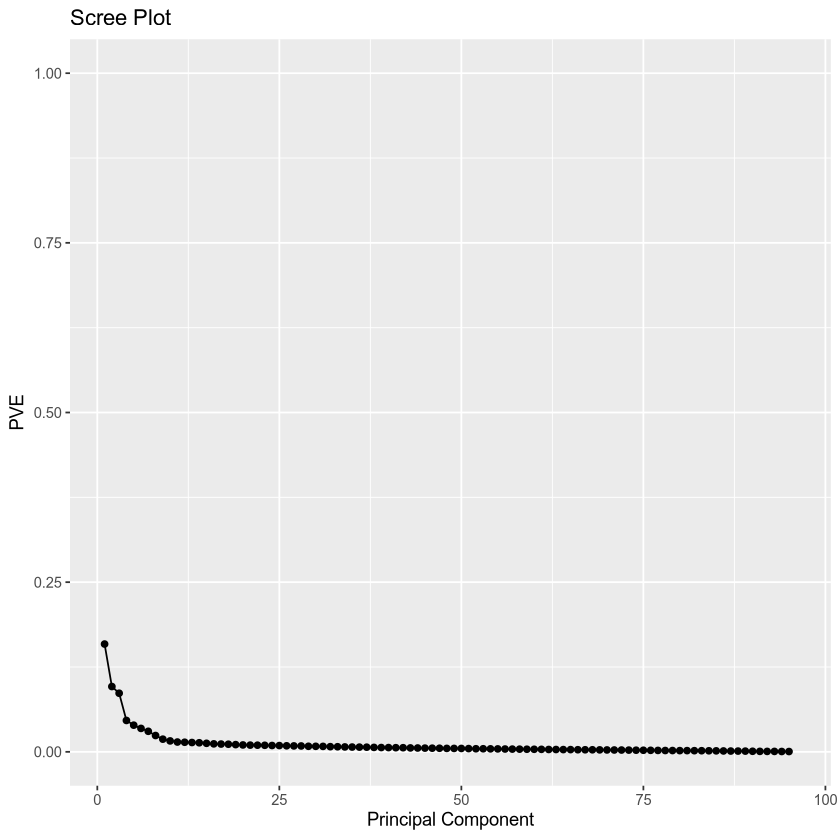

$names
[1] "sdev"     "rotation" "center"   "scale"    "x"       

$class
[1] "prcomp"

Importance of components:
                          PC1     PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     3.9045 3.03880 2.87875 2.10617 1.94130 1.8199 1.70385
Proportion of Variance 0.1588 0.09619 0.08632 0.04621 0.03926 0.0345 0.03024
Cumulative Proportion  0.1588 0.25499 0.34132 0.38753 0.42678 0.4613 0.49152
                           PC8     PC9    PC10    PC11   PC12   PC13    PC14
Standard deviation     1.51860 1.33744 1.24168 1.17636 1.1635 1.1469 1.13108
Proportion of Variance 0.02402 0.01863 0.01606 0.01441 0.0141 0.0137 0.01333
Cumulative Proportion  0.51554 0.53418 0.55024 0.56465 0.5787 0.5925 0.60578
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     1.09691 1.06109 1.04731 1.03567 1.00924 0.98541 0.97311
Proportion of Variance 0.01253 0.01173 0.01143 0.01117 0.01061 0.01011 0.00986
Cumulative Proportion  0.61831 0.63004 0.64147 0.65264 0.66325 0.67336 0.68323
                          PC22    PC23    

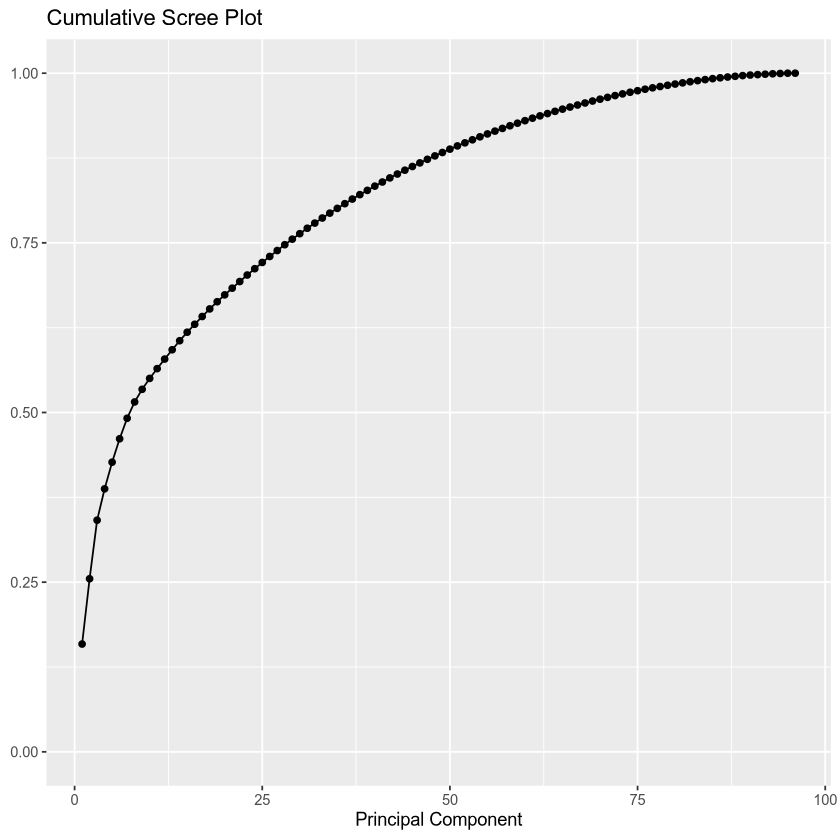

In [ ]:
#Subset to only the numerical variables to evaluate
PCA_dat = prop_matrix
apply(PCA_dat, 2, var)
##Scale Data
scaled_df <- apply(PCA_dat, 2, scale)

##Get the Covariance Matrix
arrests.cov <- cov(scaled_df)
##Get the eigenvectors and eigenvalues
arrests.eigen <- eigen(arrests.cov)
#str(arrests.eigen)

##To the two first components, change the sign for interpretation
##To the two first components, change the sign for interpretation
phi <- arrests.eigen$vectors[,1:10]
phi <- -phi

##Names the columns
row.names(phi) <- colnames(PCA_dat)
colnames(phi) <- c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6",
                   "PC7", "PC8", "PC9", "PC10")

##Calculate the coordinates for each for each PC
PC1 <- as.matrix(scaled_df) %*% phi[,1]
PC2 <- as.matrix(scaled_df) %*% phi[,2]
PC3 <- as.matrix(scaled_df) %*% phi[,3]
PC4 <- as.matrix(scaled_df) %*% phi[,4]
PC5 <- as.matrix(scaled_df) %*% phi[,5]
PC6 <- as.matrix(scaled_df) %*% phi[,6]
PC7 <- as.matrix(scaled_df) %*% phi[,7]
PC8 <- as.matrix(scaled_df) %*% phi[,8]
PC9 <- as.matrix(scaled_df) %*% phi[,9]
PC10 <- as.matrix(scaled_df) %*% phi[,10]

# Create data frame with Principal Components scores
PC <- data.frame(crypt_sample = row.names(PCA_dat), PC1, PC2,
                 PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10)

PC <- merge(PC, combined_df, by = "crypt_sample")

# Plot Principal Components for the two studies
ggplot(PC, aes(PC1, PC2, color = study)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() + stat_ellipse(level = 0.95, aes(fill = study),
                              alpha = 0.3, geom = "polygon")

##Get proportion of variation on each eigenvector
PVE <- arrests.eigen$values / sum(arrests.eigen$values)
round(PVE, 2)

# PVE (aka scree) plot
qplot(c(1:96), PVE) +
  geom_line() +
  xlab("Principal Component") +
  ylab("PVE") +
  ggtitle("Scree Plot") +
  ylim(0, 1)

# Cumulative PVE plot
qplot(c(1:96), cumsum(PVE)) +
  geom_line() +
  xlab("Principal Component") +
  ylab(NULL) +
  ggtitle("Cumulative Scree Plot") +
  ylim(0,1)

##Using the prcomp function
pc <- prcomp(PCA_dat,
             center = TRUE,
             scale. = TRUE)
attributes(pc)

##Rotate the loadings -- similar as above
pc$rotation <- -1*pc$rotation

#display principal components
summary(pc)

[1] 5.480495e-05 2.082938e-05 4.468920e-06 4.051099e-05 1.372311e-05
 [6] 4.784213e-06 1.129558e-06 9.310290e-06 5.458038e-05 3.184571e-05
[11] 3.782993e-05 4.522170e-05 3.329239e-05 1.345548e-05 1.443767e-05
[16] 5.197641e-05 1.168399e-04 2.870303e-05 1.649397e-05 4.282407e-04
[21] 4.414873e-06 1.604689e-06 3.029464e-06 5.266222e-06 1.080006e-04
[26] 4.739816e-05 5.093107e-06 1.005930e-04 4.816781e-06 4.941203e-06
[31] 1.072864e-06 7.158826e-06 4.616212e-05 4.838746e-05 2.514038e-05
[36] 5.896662e-05 9.828974e-05 1.259028e-05 1.417796e-04 5.865314e-05
[41] 1.116987e-05 2.590004e-05 1.074796e-05 1.230282e-05 2.222909e-06
[46] 2.224199e-06 6.124089e-06 4.737071e-06 9.020034e-05 3.471958e-05
[51] 4.316933e-06 5.192823e-05 3.162268e-06 3.134804e-06 6.347852e-07
[56] 4.239558e-06 4.164881e-05 4.938523e-05 3.299124e-05 3.537944e-05
[61] 8.551724e-05 2.785508e-06 6.946153e-05 4.343324e-05 2.634250e-05
[66] 1.248467e-05 1.047759e-05 2.187227e-05 2.437290e-06 1.175314e-06
[71] 8.093844e-06 7.872855e-06 1.318045e-04 9.622277e-05 2.140257e-05
[76] 1.664465e-04 1.783228e-05 6.625367e-06 7.353179e-07 3.369892e-05
[81] 7.108447e-05 5.884821e-05 2.722942e-05 5.479898e-05 3.014589e-05
[86] 7.353854e-06 1.157122e-05 1.666535e-04 1.400734e-05 9.951248e-06
[91] 8.755477e-06 2.346077e-04 5.472513e-06 4.552090e-06 4.099186e-06
[96] 1.222695e-04

[1] 0.16 0.10 0.09 0.05 0.04 0.03 0.03 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01
[16] 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
[31] 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
[46] 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
[61] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
[76] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
[91] 0.00 0.00 0.00 0.00 0.00 0.00

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


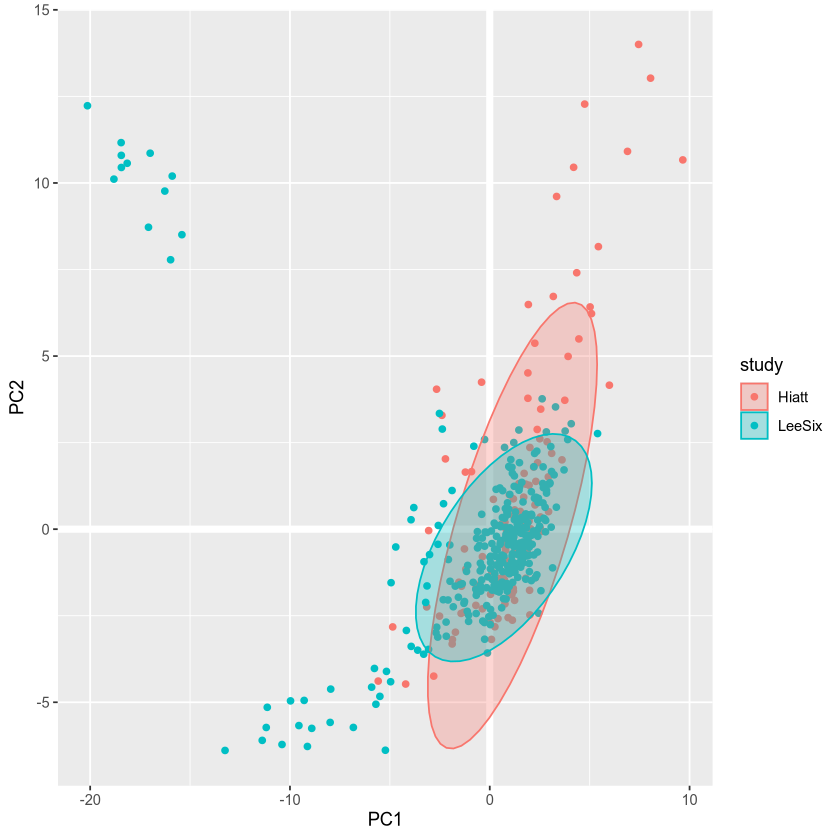

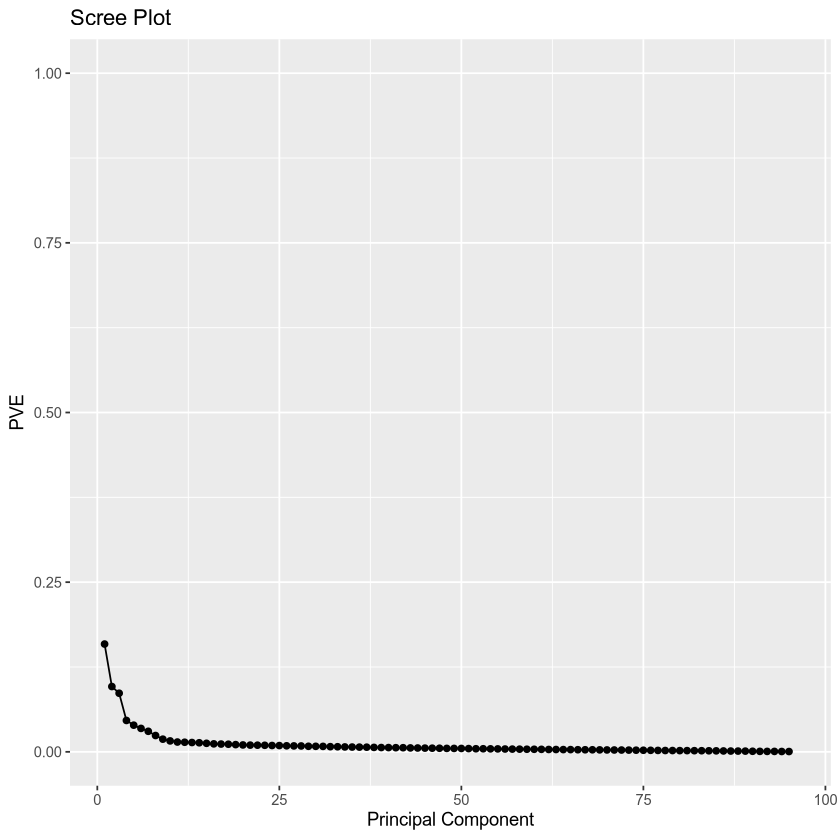

$names
[1] "sdev"     "rotation" "center"   "scale"    "x"       

$class
[1] "prcomp"

Importance of components:
                          PC1     PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     3.9045 3.03880 2.87875 2.10617 1.94130 1.8199 1.70385
Proportion of Variance 0.1588 0.09619 0.08632 0.04621 0.03926 0.0345 0.03024
Cumulative Proportion  0.1588 0.25499 0.34132 0.38753 0.42678 0.4613 0.49152
                           PC8     PC9    PC10    PC11   PC12   PC13    PC14
Standard deviation     1.51860 1.33744 1.24168 1.17636 1.1635 1.1469 1.13108
Proportion of Variance 0.02402 0.01863 0.01606 0.01441 0.0141 0.0137 0.01333
Cumulative Proportion  0.51554 0.53418 0.55024 0.56465 0.5787 0.5925 0.60578
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     1.09691 1.06109 1.04731 1.03567 1.00924 0.98541 0.97311
Proportion of Variance 0.01253 0.01173 0.01143 0.01117 0.01061 0.01011 0.00986
Cumulative Proportion  0.61831 0.63004 0.64147 0.65264 0.66325 0.67336 0.68323
                          PC22    PC23    

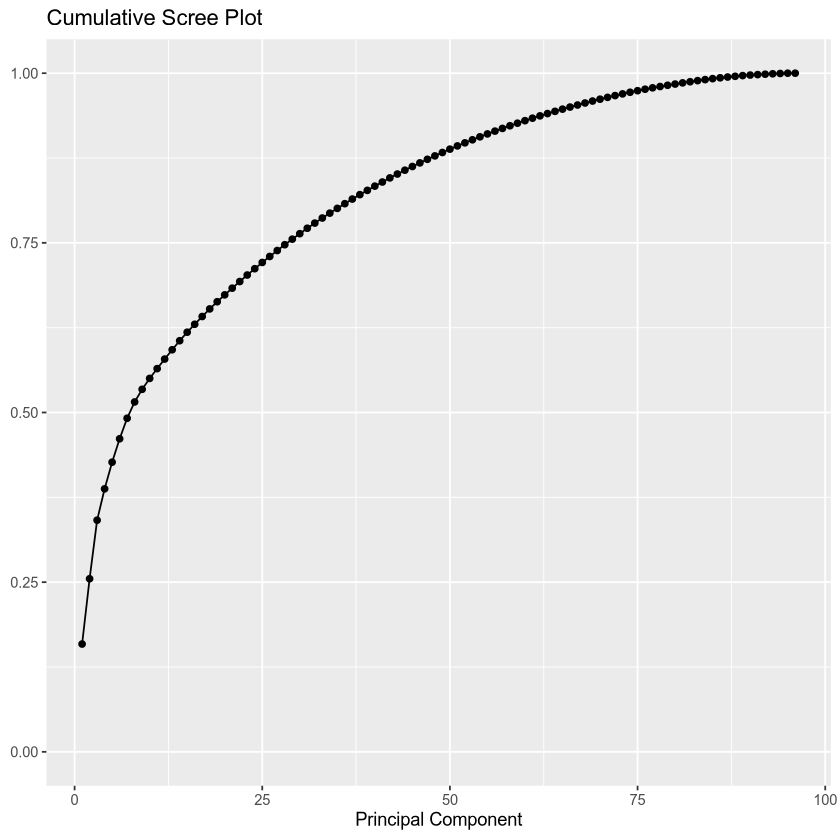

In [134]:
#Subset to only the numerical variables to evaluate
PCA_dat = prop_matrix
apply(PCA_dat, 2, var)
##Scale Data
scaled_df <- apply(PCA_dat, 2, scale)

##Get the Covariance Matrix
arrests.cov <- cov(scaled_df)
##Get the eigenvectors and eigenvalues
arrests.eigen <- eigen(arrests.cov)
#str(arrests.eigen)

##To the two first components, change the sign for interpretation
##To the two first components, change the sign for interpretation
phi <- arrests.eigen$vectors[,1:10]
phi <- -phi

##Names the columns
row.names(phi) <- colnames(PCA_dat)
colnames(phi) <- c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6",
                   "PC7", "PC8", "PC9", "PC10")

##Calculate the coordinates for each for each PC
PC1 <- as.matrix(scaled_df) %*% phi[,1]
PC2 <- as.matrix(scaled_df) %*% phi[,2]
PC3 <- as.matrix(scaled_df) %*% phi[,3]
PC4 <- as.matrix(scaled_df) %*% phi[,4]
PC5 <- as.matrix(scaled_df) %*% phi[,5]
PC6 <- as.matrix(scaled_df) %*% phi[,6]
PC7 <- as.matrix(scaled_df) %*% phi[,7]
PC8 <- as.matrix(scaled_df) %*% phi[,8]
PC9 <- as.matrix(scaled_df) %*% phi[,9]
PC10 <- as.matrix(scaled_df) %*% phi[,10]

# Create data frame with Principal Components scores
PC <- data.frame(crypt_sample = row.names(PCA_dat), PC1, PC2,
                 PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10)

PC <- merge(PC, combined_df, by = "crypt_sample")

# Plot Principal Components for the two studies
ggplot(PC, aes(PC1, PC2, color = study)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() + stat_ellipse(level = 0.95, aes(fill = study),
                              alpha = 0.3, geom = "polygon")

##Get proportion of variation on each eigenvector
PVE <- arrests.eigen$values / sum(arrests.eigen$values)
round(PVE, 2)

# PVE (aka scree) plot
qplot(c(1:96), PVE) +
  geom_line() +
  xlab("Principal Component") +
  ylab("PVE") +
  ggtitle("Scree Plot") +
  ylim(0, 1)

# Cumulative PVE plot
qplot(c(1:96), cumsum(PVE)) +
  geom_line() +
  xlab("Principal Component") +
  ylab(NULL) +
  ggtitle("Cumulative Scree Plot") +
  ylim(0,1)

##Using the prcomp function
pc <- prcomp(PCA_dat,
             center = TRUE,
             scale. = TRUE)
attributes(pc)

##Rotate the loadings -- similar as above
pc$rotation <- -1*pc$rotation

#display principal components
summary(pc)

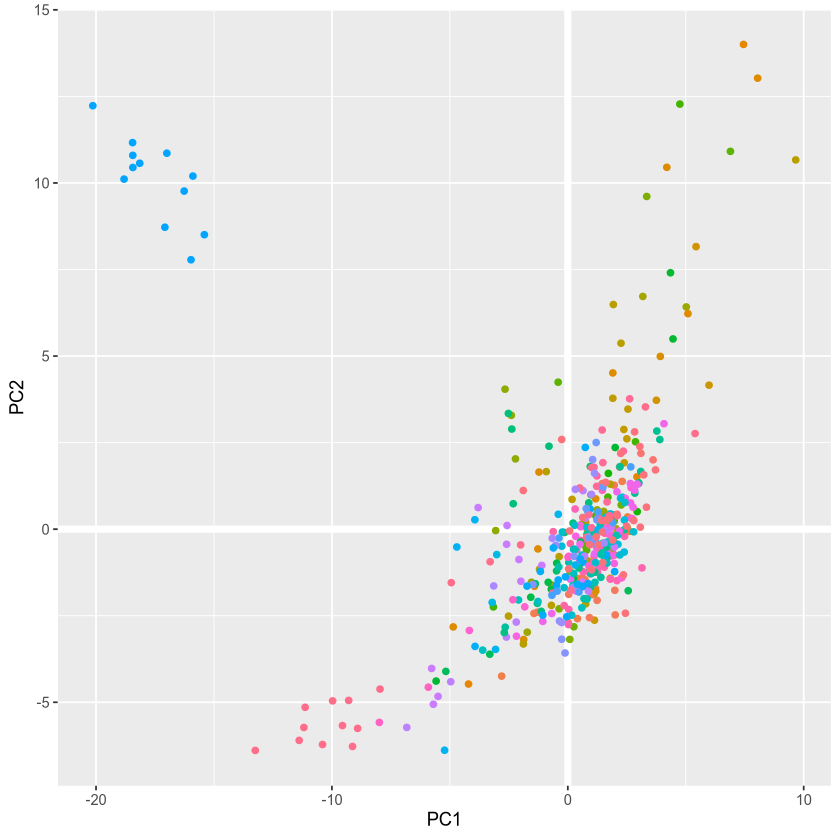

In [135]:
ggplot(PC, aes(PC1, PC2, color = donor)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() + theme(legend.position = "none")

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


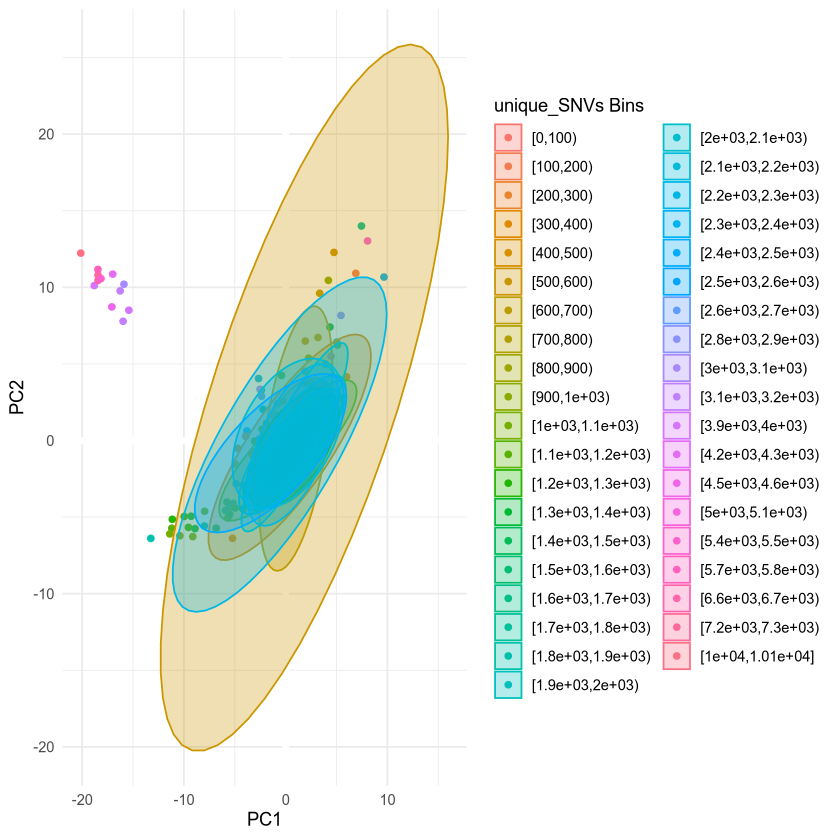

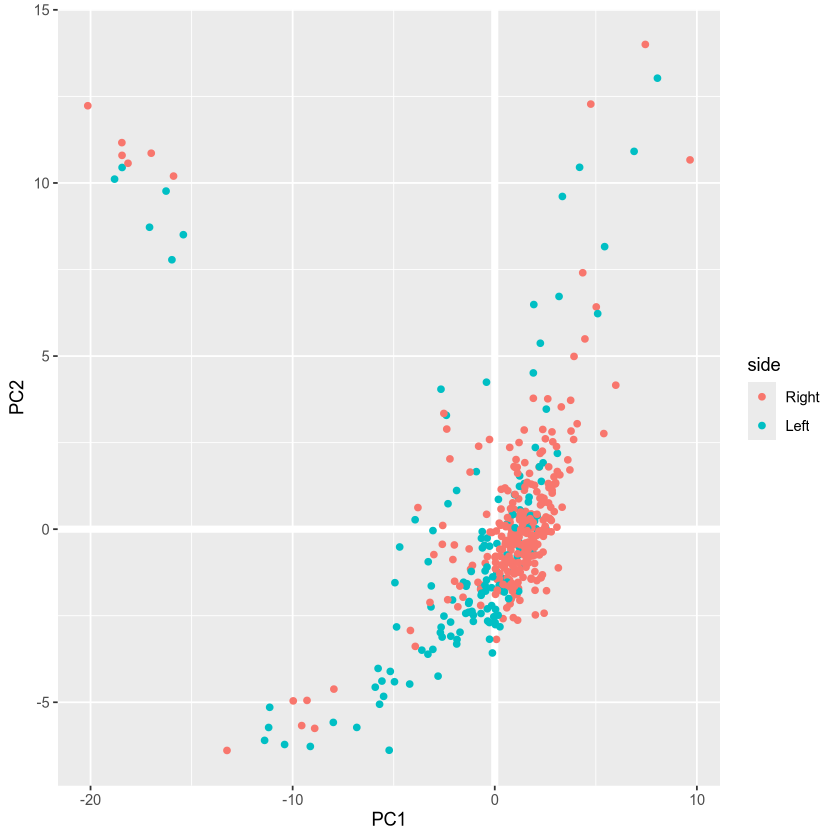

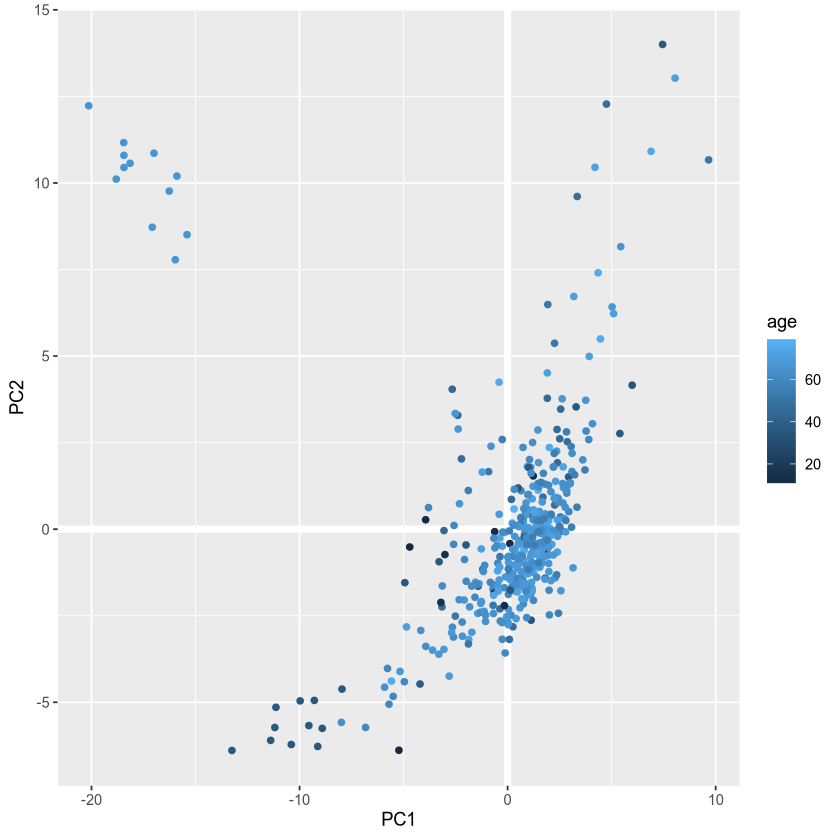

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


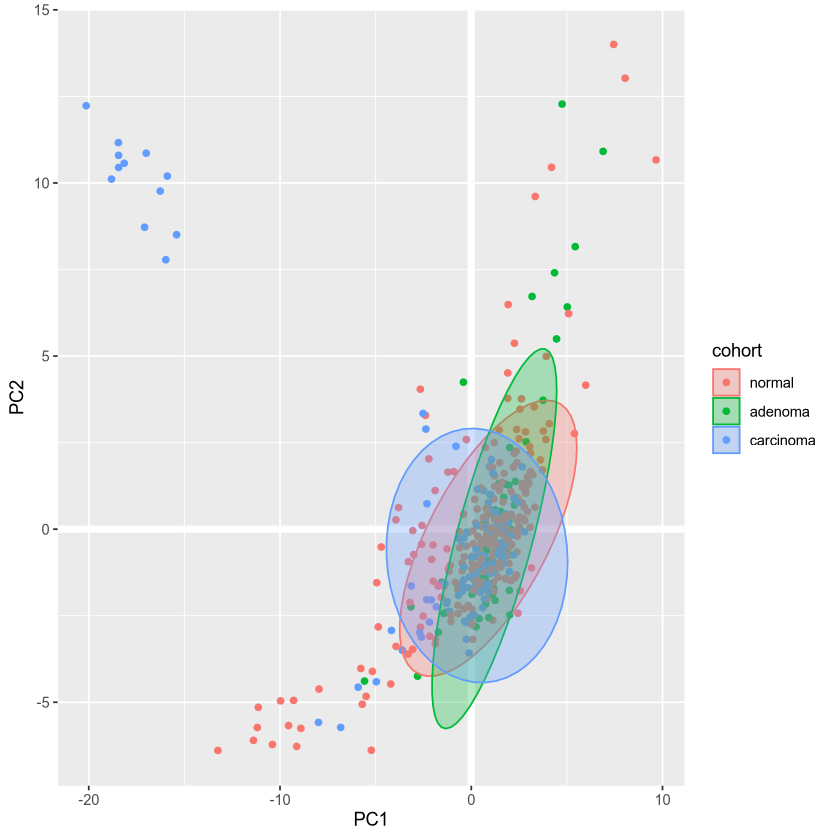

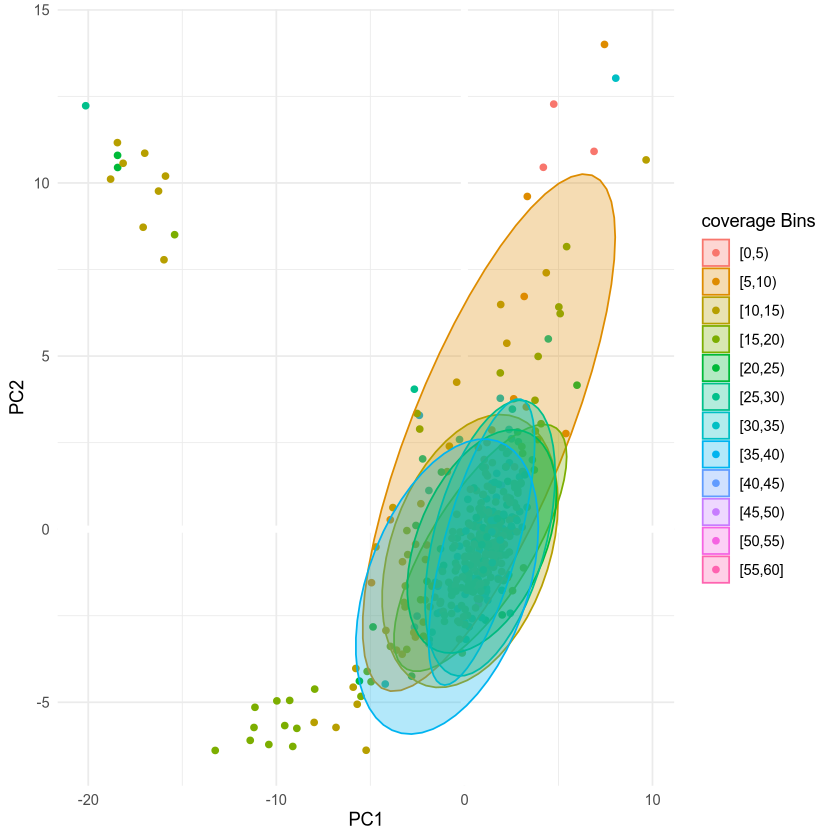

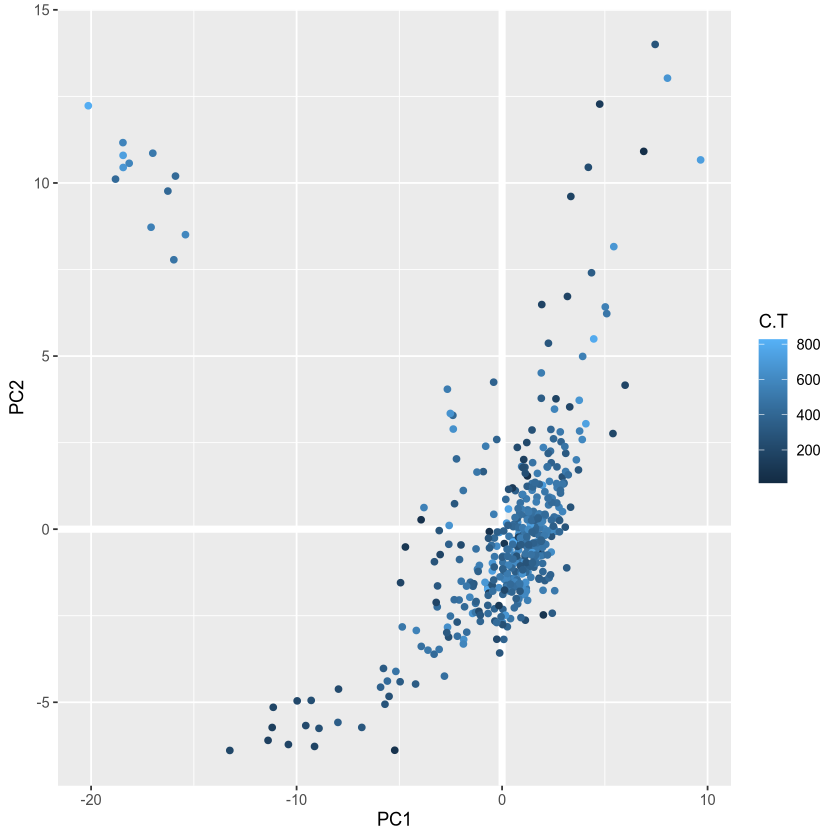

In [136]:
PC <- PC %>%
  mutate(unique_SNVs_bin = cut(unique_SNVs, breaks = seq(0, max(unique_SNVs, na.rm = TRUE) + 100, by = 100),
                            include.lowest = TRUE, right = FALSE))

# Plot PCA with binned unique_SNVs values
ggplot(PC, aes(PC1, PC2, color = unique_SNVs_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = unique_SNVs_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "unique_SNVs Bins") +
  scale_fill_discrete(name = "unique_SNVs Bins") +
  theme_minimal()

ggplot(PC, aes(PC1, PC2, color = side)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point()

ggplot(PC, aes(PC1, PC2, color = age)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point()

ggplot(PC, aes(PC1, PC2, color = cohort)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() + stat_ellipse(level = 0.95, aes(fill = cohort),
                             alpha = 0.3, geom = "polygon")

PC <- PC %>%
  mutate(coverage_bin = cut(coverage, breaks = seq(0, max(coverage, na.rm = TRUE) + 5, by = 5),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned coverage values
ggplot(PC, aes(PC1, PC2, color = coverage_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = coverage_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "coverage Bins") +
  scale_fill_discrete(name = "coverage Bins") +
  theme_minimal()

ggplot(PC, aes(PC1, PC2, color = C.T)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point()

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


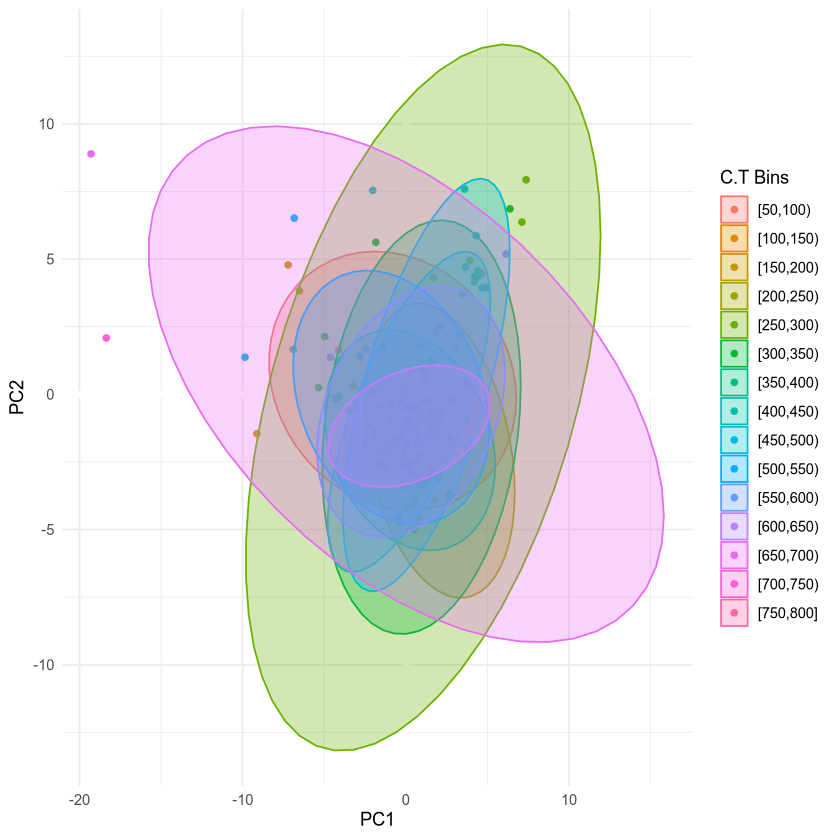

In [131]:
PC <- PC %>%
  mutate(CT_bin = cut(C.T, breaks = seq(0, max(C.T, na.rm = TRUE) + 50, by = 50),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned C.T values
ggplot(PC, aes(PC1, PC2, color = CT_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = CT_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "C.T Bins") +
  scale_fill_discrete(name = "C.T Bins") +
  theme_minimal()


Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


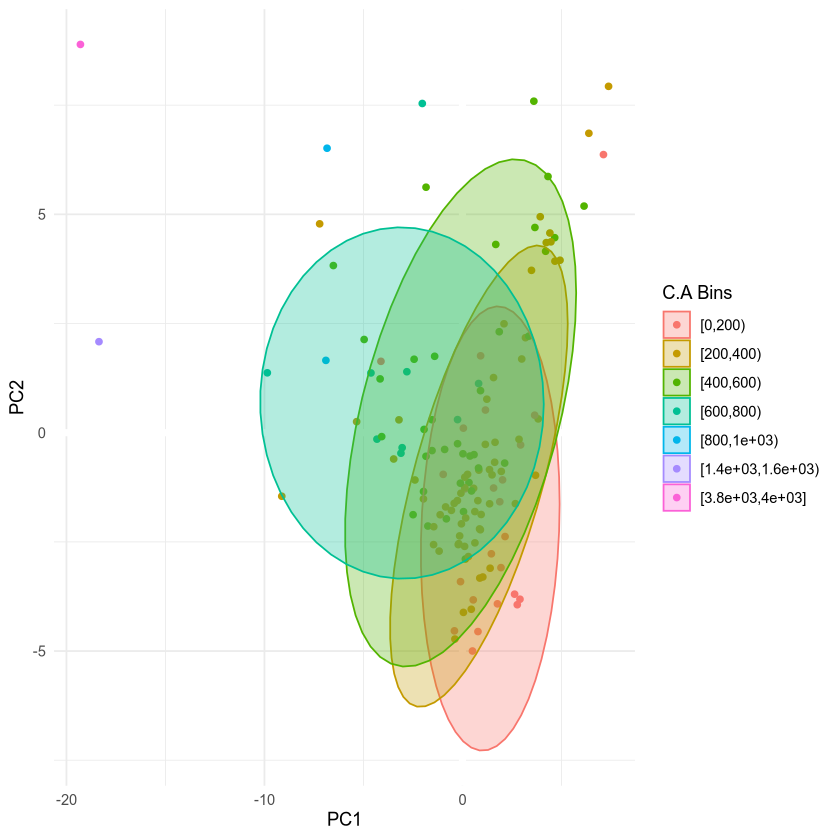

In [133]:
PC <- PC %>%
  mutate(CA_bin = cut(C.A, breaks = seq(0, max(C.A, na.rm = TRUE) + 200, by = 200),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned C.A values
ggplot(PC, aes(PC1, PC2, color = CA_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = CA_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "C.A Bins") +
  scale_fill_discrete(name = "C.A Bins") +
  theme_minimal()

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


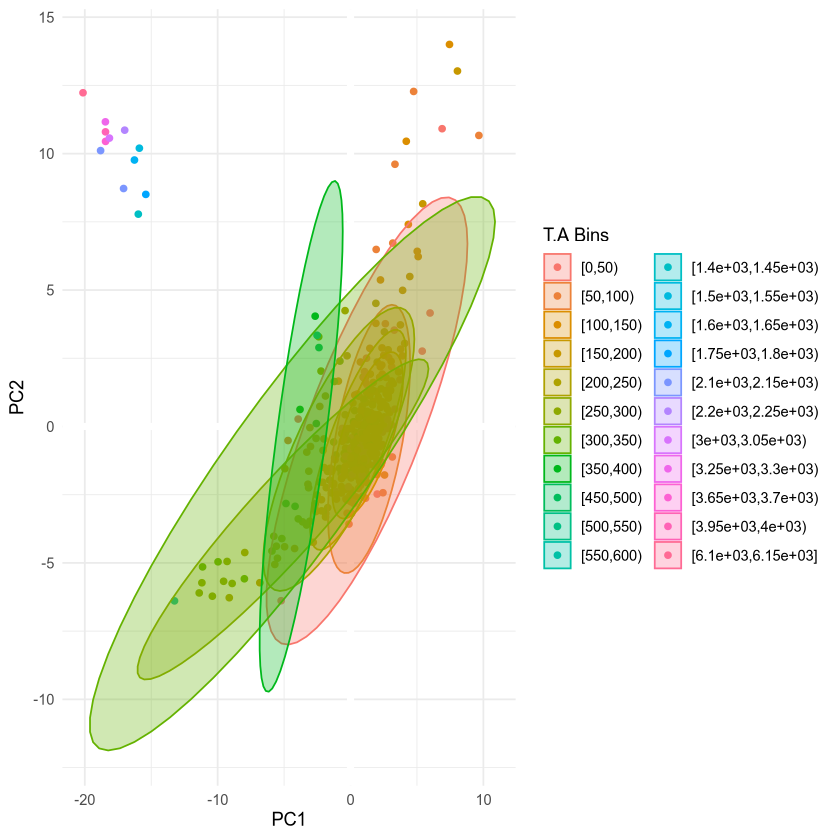

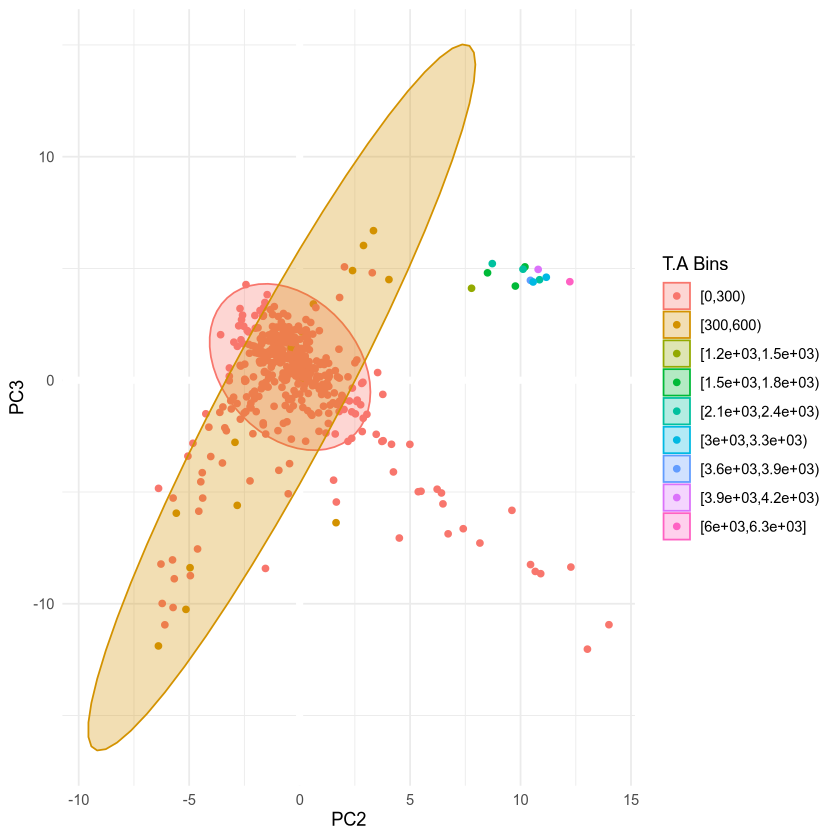

In [ ]:
PC <- PC %>%
  mutate(TA_bin = cut(T.A, breaks = seq(0, max(T.A, na.rm = TRUE) + 50, by = 50),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned T.A values
ggplot(PC, aes(PC1, PC2, color = TA_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = TA_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "T.A Bins") +
  scale_fill_discrete(name = "T.A Bins") +
  theme_minimal()

# Create bins of width 50 for T.A
PC <- PC %>%
  mutate(TA_bin = cut(T.A, breaks = seq(0, max(T.A, na.rm = TRUE) + 300, by = 300),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned T.A values
ggplot(PC, aes(PC2, PC3, color = TA_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = TA_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "T.A Bins") +
  scale_fill_discrete(name = "T.A Bins") +
  theme_minimal()

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


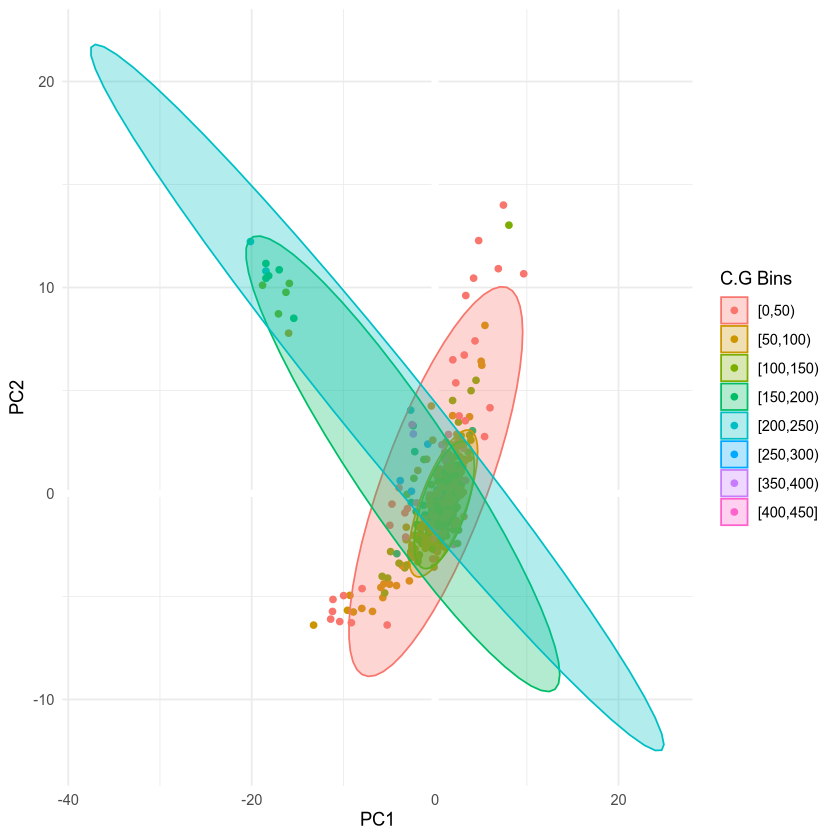

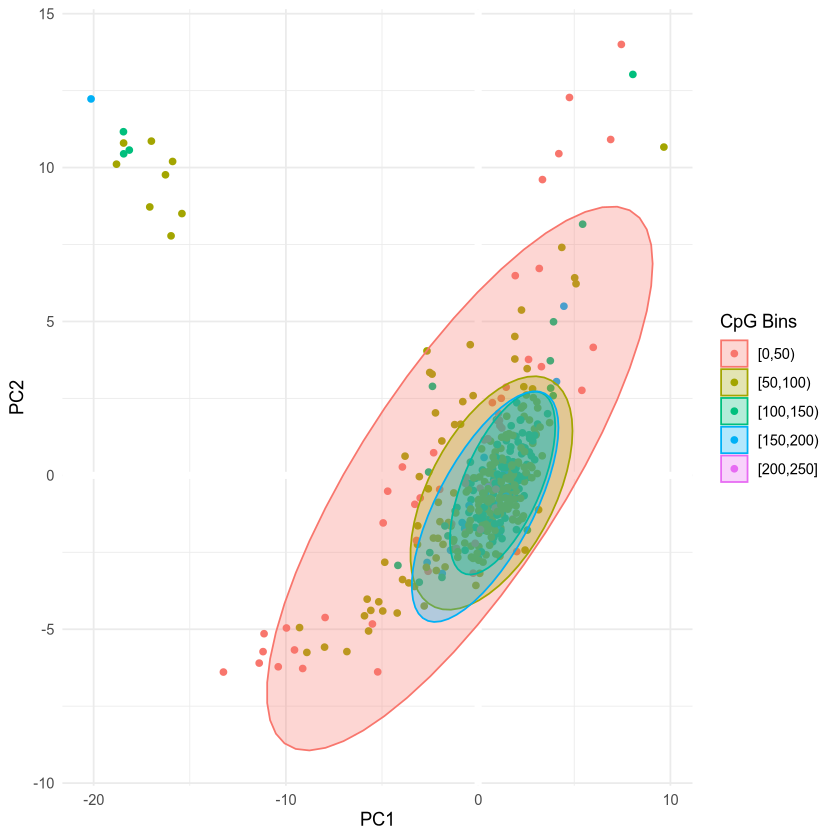

In [ ]:
PC <- PC %>%
  mutate(CG_bin = cut(C.G, breaks = seq(0, max(C.G, na.rm = TRUE) + 50, by = 50),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned C.G values
ggplot(PC, aes(PC1, PC2, color = CG_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = CG_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "C.G Bins") +
  scale_fill_discrete(name = "C.G Bins") +
  theme_minimal()

# Create bins of width 50 for CpG
PC <- PC %>%
  mutate(CpG_bin = cut(CpG, breaks = seq(0, max(CpG, na.rm = TRUE) + 50, by = 50),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned CpG values
ggplot(PC, aes(PC1, PC2, color = CpG_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = CpG_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "CpG Bins") +
  scale_fill_discrete(name = "CpG Bins") +
  theme_minimal()

Too few points to calculate an ellipse


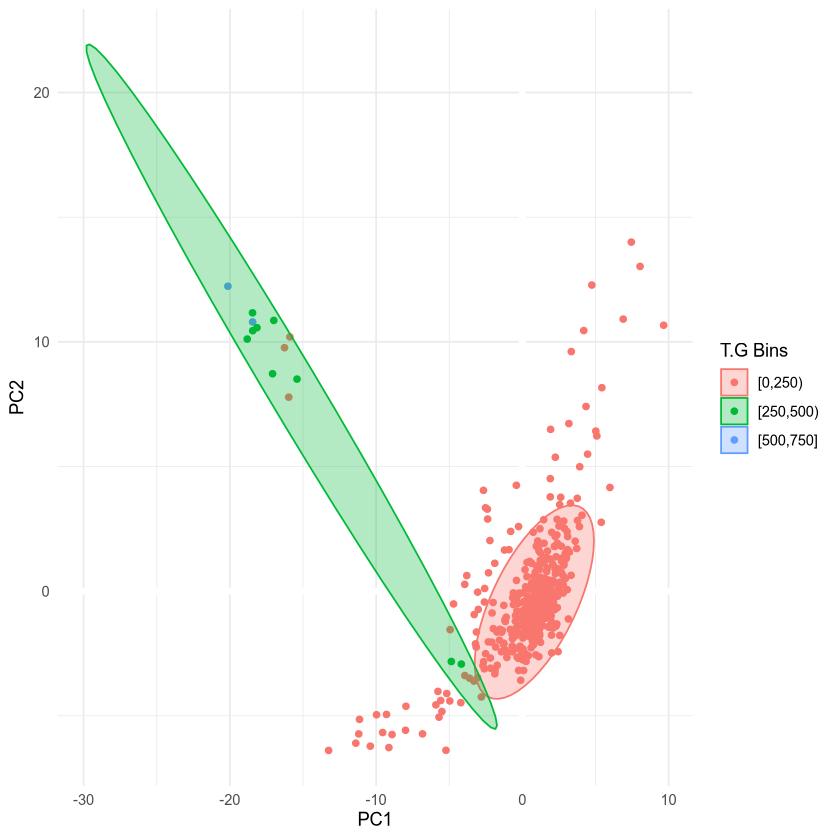

In [ ]:
PC <- PC %>%
  mutate(TG_bin = cut(T.G, breaks = seq(0, max(T.G, na.rm = TRUE) + 250, by = 250),
                      include.lowest = TRUE, right = FALSE))

# Plot PCA with binned T.G values
ggplot(PC, aes(PC1, PC2, color = TG_bin)) +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  geom_point() +
  stat_ellipse(level = 0.95, aes(fill = TG_bin),
               alpha = 0.3, geom = "polygon") +
  scale_color_discrete(name = "T.G Bins") +
  scale_fill_discrete(name = "T.G Bins") +
  theme_minimal()

[1] -0.26391550  0.11737886  2.03734006  3.58999761  2.45445082  0.65534724
 [7]  1.03556525  0.55088669  0.31738424  0.62347958  0.45079618  0.15438911
[13]  1.65638114  1.56729145  1.40309559  2.79058506  1.84364750  1.48147073
[19]  0.08916451  2.66861770  2.09444065  0.88963572  0.46875226  0.30989720
[25]  3.06461002  2.92471376  1.49518523  3.55776434  0.98750435  1.94857549
[31]  1.08581477  0.29651064  1.65746332  0.52897956  0.12762089  1.44187645
[37]  4.47705635  2.13538206  5.06303744  4.49856949  2.98032370  3.89272449
[43]  0.44311764  0.47058572  1.07392565  0.67961885  1.53477087  0.41288548
[49]  0.54916371  2.91739788  0.48932561  0.90350165  0.97751899  0.72713902
[55]  1.93307925  2.10652223  1.19612237  0.14598700 -0.09518500 -0.16916042
[61]  5.45703010  0.67698979  5.22250869  4.98339289  2.11239698  2.44508357
[67]  0.77034590  0.36189459  1.42531630  1.41620707  3.40031978  7.95443934
[73]  1.96227570  2.28033066 12.30620769  1.14878707  4.87335487  0.51775453
[79]  0.96152801  3.44633078  1.60499478  0.25092773  0.39512358  0.68290400
[85]  2.15707468  1.41223859  2.78625249  4.04508069  0.07396517  0.44008479
[91]  0.52968198  2.65031944  0.75393409  1.07979413  0.72109756  2.68081695

[1] 5.480495e-05 2.082938e-05 4.468920e-06 4.051099e-05 1.372311e-05
 [6] 4.784213e-06 1.129558e-06 9.310290e-06 5.458038e-05 3.184571e-05
[11] 3.782993e-05 4.522170e-05 3.329239e-05 1.345548e-05 1.443767e-05
[16] 5.197641e-05 1.168399e-04 2.870303e-05 1.649397e-05 4.282407e-04
[21] 4.414873e-06 1.604689e-06 3.029464e-06 5.266222e-06 1.080006e-04
[26] 4.739816e-05 5.093107e-06 1.005930e-04 4.816781e-06 4.941203e-06
[31] 1.072864e-06 7.158826e-06 4.616212e-05 4.838746e-05 2.514038e-05
[36] 5.896662e-05 9.828974e-05 1.259028e-05 1.417796e-04 5.865314e-05
[41] 1.116987e-05 2.590004e-05 1.074796e-05 1.230282e-05 2.222909e-06
[46] 2.224199e-06 6.124089e-06 4.737071e-06 9.020034e-05 3.471958e-05
[51] 4.316933e-06 5.192823e-05 3.162268e-06 3.134804e-06 6.347852e-07
[56] 4.239558e-06 4.164881e-05 4.938523e-05 3.299124e-05 3.537944e-05
[61] 8.551724e-05 2.785508e-06 6.946153e-05 4.343324e-05 2.634250e-05
[66] 1.248467e-05 1.047759e-05 2.187227e-05 2.437290e-06 1.175314e-06
[71] 8.093844e-06 7.872855e-06 1.318045e-04 9.622277e-05 2.140257e-05
[76] 1.664465e-04 1.783228e-05 6.625367e-06 7.353179e-07 3.369892e-05
[81] 7.108447e-05 5.884821e-05 2.722942e-05 5.479898e-05 3.014589e-05
[86] 7.353854e-06 1.157122e-05 1.666535e-04 1.400734e-05 9.951248e-06
[91] 8.755477e-06 2.346077e-04 5.472513e-06 4.552090e-06 4.099186e-06
[96] 1.222695e-04

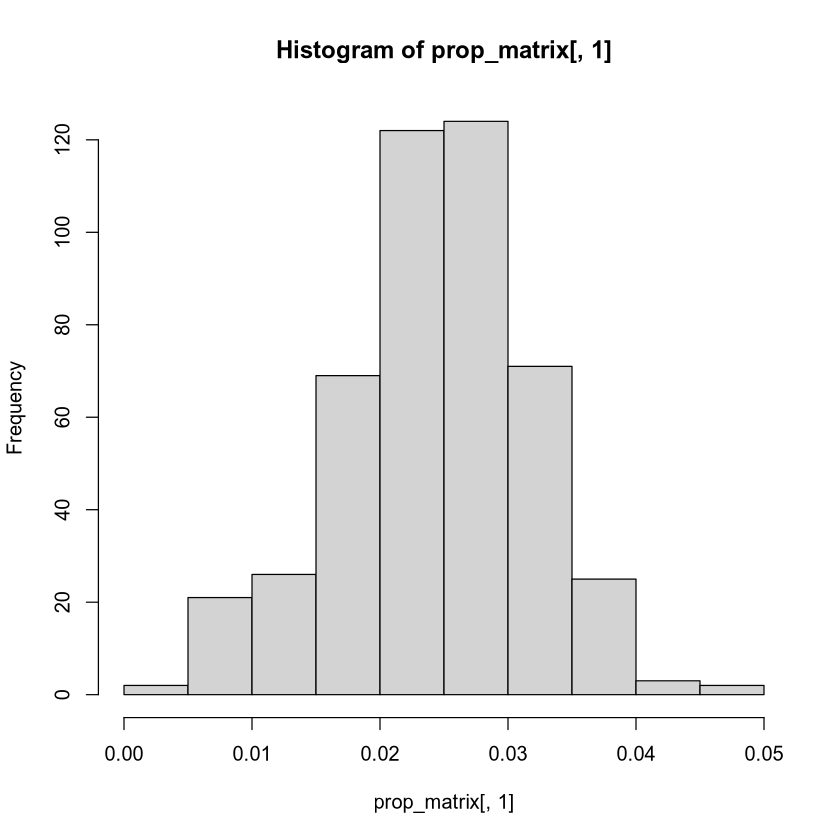

In [117]:
hist(prop_matrix[, 1])
apply(prop_matrix, 2, skewness)
apply(prop_matrix, 2, var)
pca_raw <- prcomp(prop_matrix, center = TRUE, scale. = TRUE)
pca_log <- prcomp(log1p(prop_matrix), center = TRUE, scale. = TRUE)
pca_clr <- prcomp(clr(prop_matrix), center = TRUE, scale. = TRUE)
# Compare variance explained
#summary(pca_raw)
#summary(pca_log)
#summary(pca_clr)

Warning message in geom_bar(stat = "identity", fill = barfill, color = barcolor, :
“Ignoring empty aesthetic: `width`.”


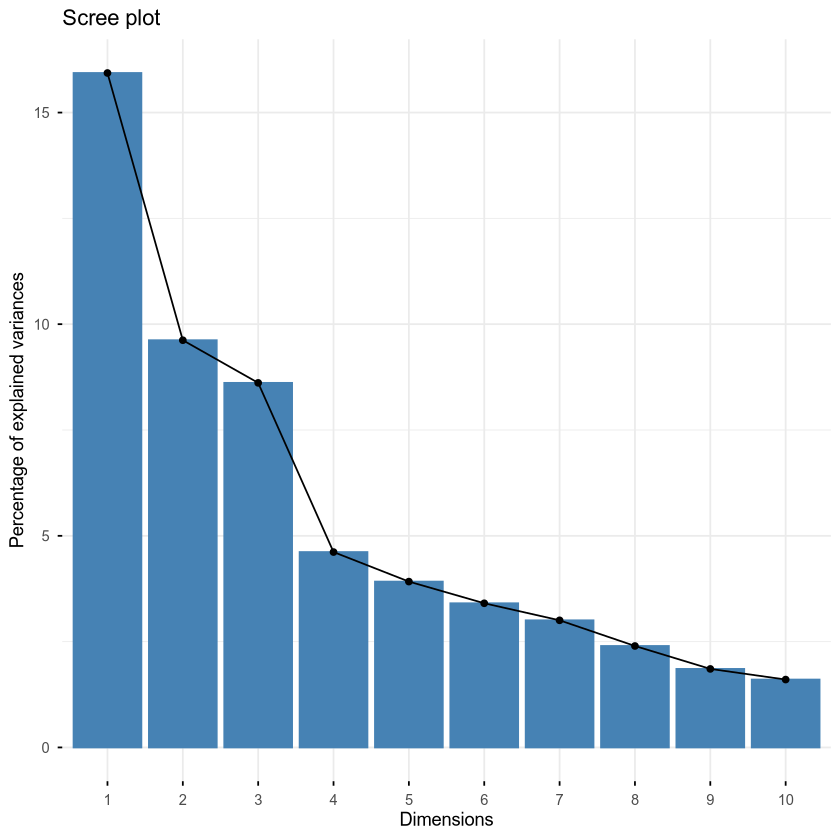

In [119]:
mutation_counts_log <- log1p(prop_matrix)

# Run PCA
pca_res <- prcomp(mutation_counts_log, center = TRUE, scale. = TRUE)
fviz_eig(pca_res)

# Merge PCA scores with cohort info
pca_data <- as.data.frame(pca_res$x)
pca_data$crypt_sample <- rownames(pca_data)
pca_data <- merge(pca_data, combined_df, by = "crypt_sample")

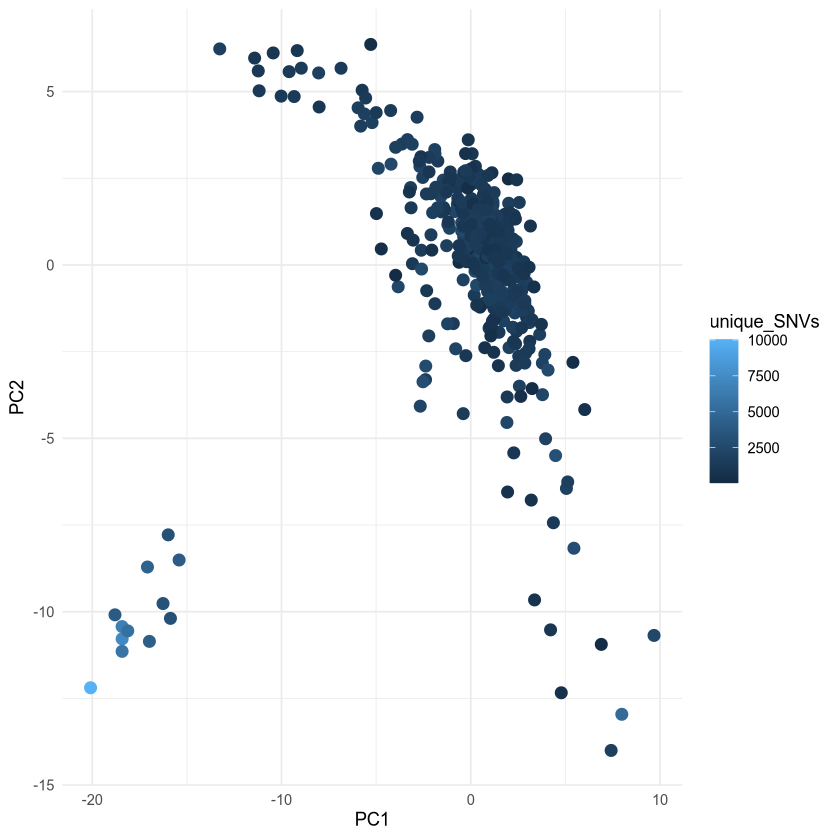

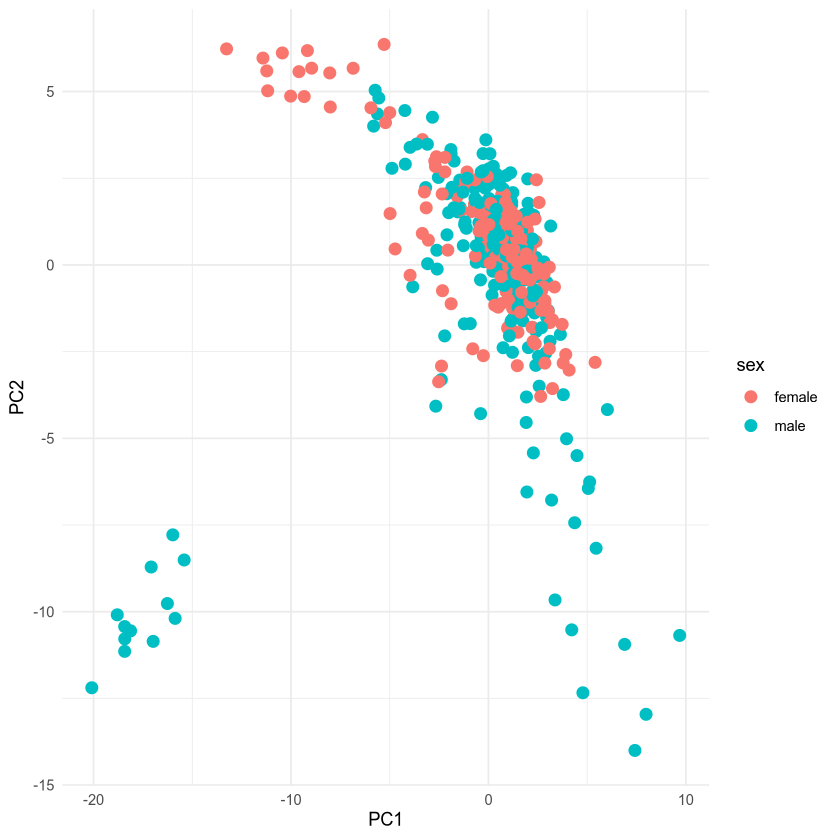

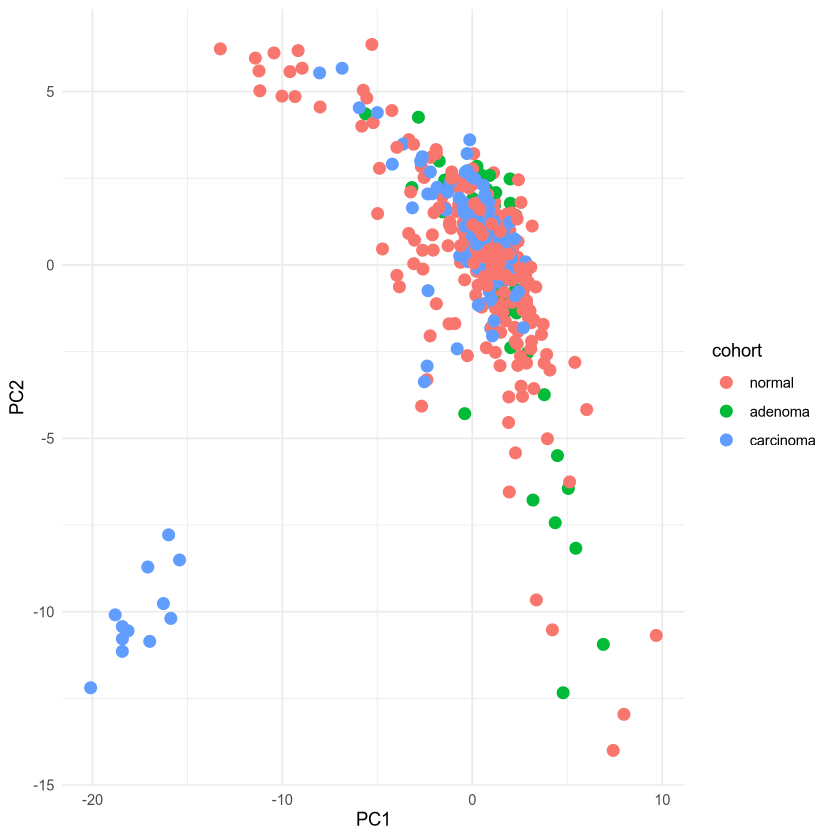

In [120]:
ggplot(pca_data, aes(x = PC1, y = PC2, color = unique_SNVs)) +
  geom_point(size = 3) +
  theme_minimal()

ggplot(pca_data, aes(x = PC1, y = PC2, color = sex)) +
  geom_point(size = 3) +
  theme_minimal()

ggplot(pca_data, aes(x = PC1, y = PC2, color = cohort)) +
  geom_point(size = 3) +
  theme_minimal()


In [126]:
loadings <- pca_res$rotation
#fviz_pca_var(pca_res,
#             col.var = "contrib", # Color by contributions
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#             repel = TRUE)

loadings_df <- as.data.frame(loadings[, 1:2])
loadings_df$mutation <- rownames(loadings_df)

# Plot
#ggplot(loadings_df, aes(x = PC1, y = PC2, label = mutation)) +
#  geom_point() +
#  geom_text(size = 3, vjust = 1, hjust = 1) +
#  theme_minimal() +
#  labs(title = "PCA Loadings Plot", x = "PC1 Loadings", y = "PC2 Loadings")

In [124]:
pc1_contrib <- sort(loadings[, "PC1"]^2, decreasing = TRUE)

# Barplot of top contributors
top_n <- 10
#barplot(pc1_contrib[1:top_n],
#        las = 2, col = "steelblue",
#        main = "Top 10 Mutation Types Contributing to PC1")

#pheatmap(loadings[, 1:5],
#         cluster_rows = TRUE,
#         cluster_cols = TRUE,
#         main = "PCA Loadings (Top 5 PCs)")

In [ ]:
Part 2: quality and coverage

In [33]:
folder_path <- "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/reports"
json_files <- list.files(
  folder_path,
  pattern = "-fastp-report\\.json$",
  full.names = TRUE
)

rows <- lapply(json_files, function(filepath) {

  data <- fromJSON(filepath)

  q20_rate <- data$summary$before_filtering$q20_rate
  q30_rate <- data$summary$before_filtering$q30_rate

  filename <- basename(filepath)
  sample_name <- str_remove(filename, "-fastp-report\\.json$")

  group <- ifelse(
    str_detect(filename, str_c(hiatt_donors, collapse = "|")),
    "Hiatt",
    "Lee-Six"
  )

  tibble(
    sample_name = sample_name,
    group = group,
    q20_rate = q20_rate,
    q30_rate = q30_rate
  )
})

df <- bind_rows(rows)


In [34]:
summary_stats <- df %>%
  group_by(group) %>%
  summarise(
    n = n(),
    avg_q20 = mean(q20_rate, na.rm = TRUE),
    avg_q30 = mean(q30_rate, na.rm = TRUE),
    .groups = "drop"
  )

In [43]:
df_long <- df %>%
  pivot_longer(
    cols = c(q20_rate, q30_rate),
    names_to = "Quality_Metric",
    values_to = "Rate"
  )

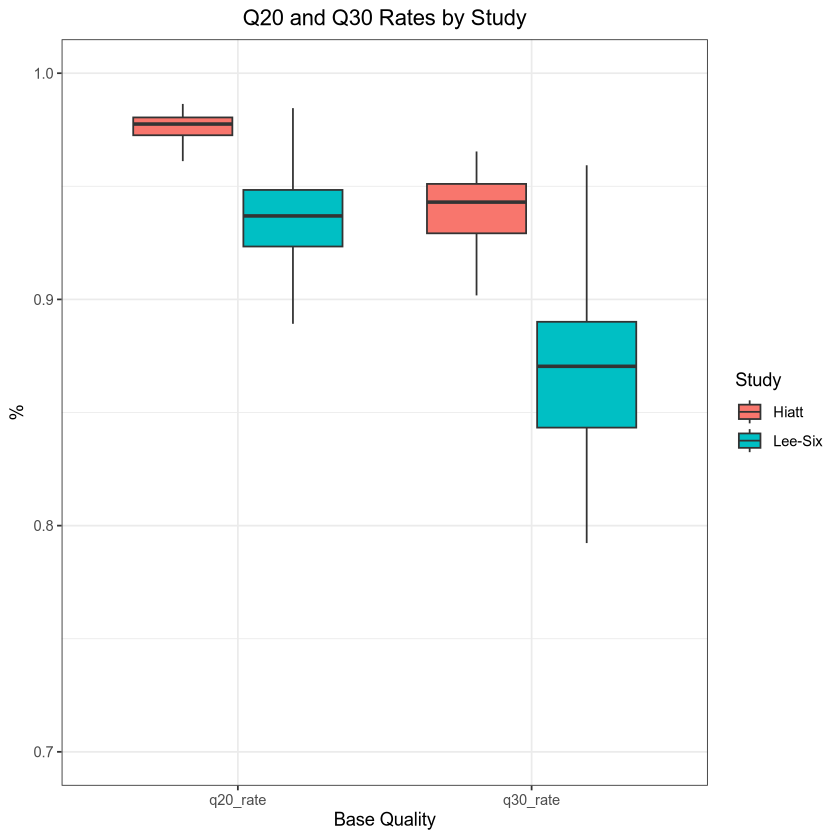

In [ ]:
p <- ggplot(df_long, aes(
  x = Quality_Metric,
  y = Rate,
  fill = group
)) +
  geom_boxplot(outlier.shape = NA) +
  coord_cartesian(ylim = c(0.7, 1.0)) +
  labs(
    title = "Q20 and Q30 Rates by Study",
    x = "Base Quality",
    y = "%",
    fill = "Study"
  ) +
  theme_bw() +
  theme(
    plot.title = element_text(hjust = 0.5)
  )

print(p)


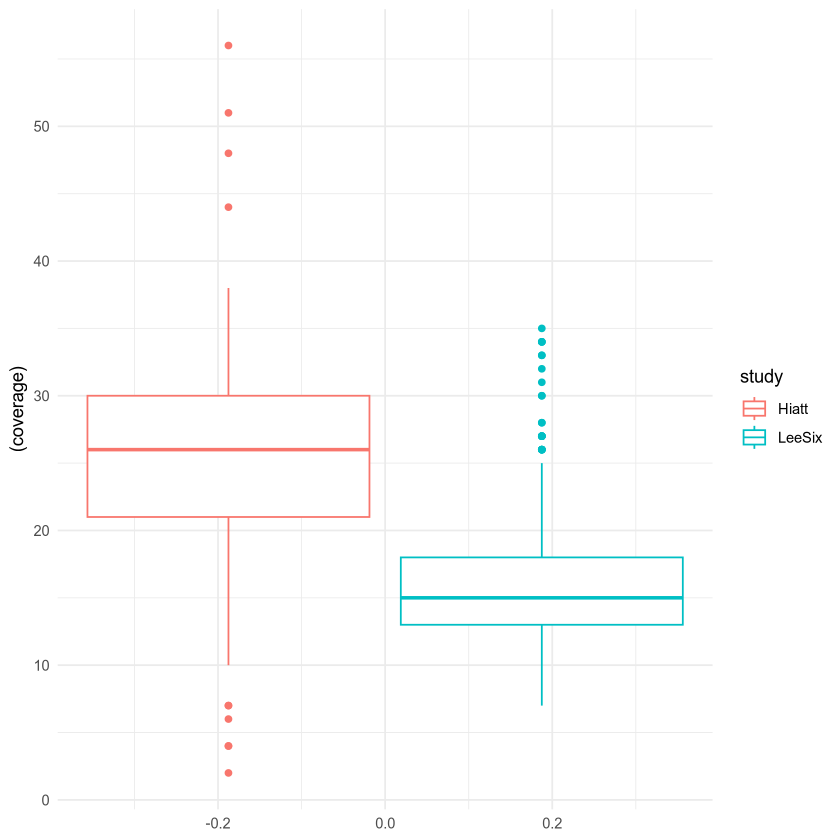

In [48]:
ggplot(combined_df) + geom_boxplot(aes(y=(coverage), color = study)) + theme_minimal()


# A tibble: 2 × 6
  study  n_samples mean_bases_covered median_bases_covered mean_fraction_covered
  <fct>      <int>              <dbl>                <dbl>                 <dbl>
1 Hiatt        124        2602084326.          2847478852.                 0.839
2 LeeSix       324        2696946697.          2790701527                  0.870
# ℹ 1 more variable: median_fraction_covered <dbl>



	Kruskal-Wallis rank sum test

data:  depth by study
Kruskal-Wallis chi-squared = 22.976, df = 1, p-value = 1.64e-06


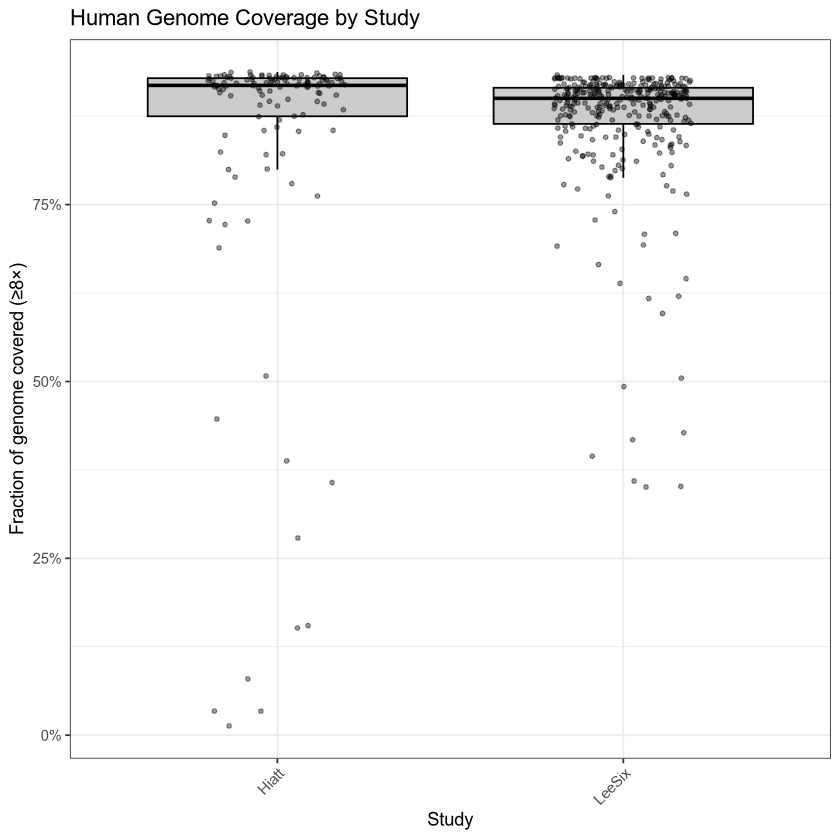

In [52]:
genome_size <- 3.1e9  # human genome (bp), adjust if needed

coverage_by_study <- combined_df %>%
  group_by(study) %>%
  summarise(
    n_samples = n(),
    mean_bases_covered = mean(depth, na.rm = TRUE),
    median_bases_covered = median(depth, na.rm = TRUE),
    mean_fraction_covered = mean(depth / genome_size, na.rm = TRUE),
    median_fraction_covered = median(depth / genome_size, na.rm = TRUE),
    .groups = "drop"
  )

print(coverage_by_study)

ggplot(combined_df, aes(
  x = study,
  y = depth / genome_size
)) +
  geom_boxplot(outlier.shape = NA, fill = "grey80", color = "black") +
  geom_jitter(width = 0.2, alpha = 0.4, size = 1) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    x = "Study",
    y = "Fraction of genome covered (≥8×)",
    title = "Human Genome Coverage by Study"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

kruskal.test(depth ~ study, data = combined_df)



Part 3: VAF

In [56]:
input_dir <- "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/txtfiles_all/snvs"
out_png <- "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/figures/plots"

dir.create(out_png, recursive = TRUE, showWarnings = FALSE)

txt_files <- list.files(input_dir, pattern = "\\.snvs_merged\\.tsv$", full.names = TRUE)


In [63]:
mutation_map <- list(
  "C>A" = c("C>A", "G>T"),
  "C>G" = c("C>G", "G>C"),
  "C>T" = c("C>T", "G>A"),
  "T>A" = c("T>A", "A>T"),
  "T>C" = c("T>C", "A>G"),
  "T>G" = c("T>G", "A>C")
)

assign_class <- function(ref, alt) {

  ref <- toupper(ref)
  alt <- toupper(alt)

  if (nchar(ref) != 1 || nchar(alt) != 1 || ref == alt)
    return(NA)

  mut <- paste0(ref, ">", alt)

  if (mut %in% c("C>A", "G>T")) return("C>A")
  if (mut %in% c("C>G", "G>C")) return("C>G")
  if (mut %in% c("C>T", "G>A")) return("C>T")
  if (mut %in% c("T>A", "A>T")) return("T>A")
  if (mut %in% c("T>C", "A>G")) return("T>C")
  if (mut %in% c("T>G", "A>C")) return("T>G")

  NA
}



In [59]:
walk(txt_files, function(f) {

  df <- read.table(f, sep = "\t", header = TRUE, comment.char = "#")
  if (!"VAF_DS" %in% colnames(df)) return()

  sample <- str_remove(basename(f), "\\.snvs_merged\\.tsv$")

  p <- ggplot(df, aes(VAF_DS)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    coord_cartesian(xlim = c(0, 1)) +
    labs(
      title = paste(sample, "- Unique SNV VAFs"),
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    theme_bw()

  ggsave(
    file.path(out_png, paste0(sample, "_vaf_hist.png")),
    p, dpi = 300, width = 8, height = 3
  )
})


In [66]:
plot_vaf_by_class <- function(txt_file, out_dir) {

  df <- read.table(txt_file, sep = "\t", header = TRUE, comment.char = "#")
  sample <- str_remove(basename(txt_file), "\\.snvs_merged\\.tsv$")

  # 🔑 Normalize REF + ALT BEFORE classification
  df$REF_base <- substr(toupper(df$REF), 1, 1)
  df$ALT_base <- toupper(df$ALT)

  # Assign SBS6 class (CpG → C, GpC → G, etc.)
  df$Class <- mapply(assign_class, df$REF_base, df$ALT_base)

  # (Optional but strongly recommended sanity check)
  if (any(is.na(df$Class))) {
    warning(
      sprintf(
        "Unclassified mutations in %s:\n%s",
        sample,
        paste(unique(paste(df$REF, df$ALT)[is.na(df$Class)]), collapse = ", ")
      )
    )
  }

  p <- ggplot(df, aes(VAF_DS)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    facet_wrap(~ Class, nrow = 2) +
    coord_cartesian(xlim = c(0, 1)) +
    labs(
      title = paste(sample, "- VAF by Mutation Type"),
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    theme_bw()

  ggsave(
    file.path(out_dir, paste0(sample, "_mutation_classes.png")),
    p, dpi = 300, width = 15, height = 8
  )
}


walk(txt_files, plot_vaf_by_class, out_dir = out_png)


In [70]:
read_and_classify <- function(files, tags) {
  map_dfr(files, function(f) {

    if (!any(str_detect(basename(f), tags))) return(NULL)

    df <- read.table(f, sep = "\t", header = TRUE, comment.char = "#")

    df$REF_base <- substr(toupper(df$REF), 1, 1)
    df$ALT_base <- toupper(df$ALT)

    df$Class <- mapply(assign_class, df$REF_base, df$ALT_base)

    df
  })
}


lee_df <- read_and_classify(txt_files, lee_donors)
hiatt_df <- read_and_classify(txt_files, hiatt_donors)


In [72]:
plot_vaf_by_class_donors <- function(df, cohort_name, out_dir) {

  p <- ggplot(df, aes(VAF_DS)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    facet_wrap(~ Class, nrow = 2) +
    coord_cartesian(xlim = c(0, 1), ylim = c(0, 10000)) +
    labs(
      title = paste(cohort_name, "- VAF by Mutation Type"),
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    theme_bw()

  ggsave(
    file.path(out_dir, paste0(cohort_name, "_mutation_classes.png")),
    p, dpi = 300, width = 15, height = 8
  )
}

if (nrow(lee_df) > 0)
  plot_vaf_by_class_donors(lee_df, "LeeSix_cohort", out_png)

if (nrow(hiatt_df) > 0)
  plot_vaf_by_class_donors(hiatt_df, "Hiatt_cohort", out_png)


In [82]:
plot_vaf_by_class_overlay <- function(df, out_dir) {

  p <- ggplot(df, aes(x = VAF_DS, fill = Cohort)) +
    geom_histogram(
      bins = 30,
      position = "identity",
      alpha = 0.5,
      color = "black"
    ) +
    facet_wrap(~ Class, nrow = 2) +
    coord_cartesian(xlim = c(0, 1), ylim = c(0, 10000)) +
    scale_fill_manual(
      values = c(
        "Lee-Six" = "steelblue",
        "Hiatt"   = "darkorange"
      ),
      breaks = c("Lee-Six", "Hiatt"),
      labels = c("Lee-Six", "Hiatt")
    ) +
    labs(
      title = "VAF by Mutation Type: Lee-Six vs Hiatt",
      x = "Variant Allele Frequency (VAF)",
      y = "Count",
      fill = "Cohort"
    ) +
    theme_bw()

  ggsave(
    file.path(out_dir, "VAF_comparison_overlay_subtypes.png"),
    p, dpi = 300, width = 15, height = 8
  )
}


big_df <- bind_rows(
    lee_df %>% mutate(Cohort = "Lee-Six"),
    hiatt_df %>% mutate(Cohort = "Hiatt")
  )


if (nrow(big_df) > 0)
  plot_vaf_by_class_overlay(big_df, out_png)


In [81]:
plot_vaf_overlay <- function(lee_df, hiatt_df, out_dir) {

  df <- bind_rows(
    lee_df %>% mutate(Cohort = "Lee-Six"),
    hiatt_df %>% mutate(Cohort = "Hiatt")
  )

  p <- ggplot(df, aes(VAF_DS, fill = Cohort)) +
    geom_histogram(
      bins = 30, position = "identity", alpha = 0.5, color = "black"
    ) +
    coord_cartesian(xlim = c(0, 1)) +
    labs(
      title = "VAF Comparison: Lee-Six vs Hiatt (Overlay)",
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    scale_fill_manual(values = c("Lee-Six" = "steelblue", "Hiatt" = "darkorange")) +
    theme_bw()

  ggsave(
    file.path(out_dir, "VAF_comparison_overlay_overall.png"),
    p, dpi = 300, width = 10, height = 6
  )
}

if (nrow(hiatt_df) > 0)
  plot_vaf_overlay(lee_df, hiatt_df, out_png)
